# **SpineScope Project - Jackie Vescio**

**Note:** This notebook assumes the dataset is already loaded as `df`. 
The following sections explore the data, engineer features, and evaluate multiple classification models to identify the best-performing algorithm for spinal condition prediction.


In [1]:
# ==== Notebook Init (SpineScope) ====
import os, sys, warnings
import numpy as np
import pandas as pd

# Quiet down noisy warnings during EDA/training
warnings.filterwarnings("ignore")

# Nicer pandas display
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# Make sure we can import from the repo's scripts/ folder
# (look for scripts/model_helpers.py by walking up a few parents)
CANDIDATES = [".", "..", "../..", "../../.."]
project_root = None
for cand in CANDIDATES:
    if os.path.isfile(os.path.join(cand, "scripts", "model_helpers.py")):
        project_root = os.path.abspath(cand)
        break

if not project_root:
    raise FileNotFoundError(
        "Couldn't find scripts/model_helpers.py in ., .., ../.., or ../../.. . "
        "Adjust CANDIDATES if your notebook moved."
    )

if project_root not in sys.path:
    sys.path.insert(0, project_root)

DATA_DIR = os.path.join(project_root, "data")
print("Project root:", project_root)
print("Data dir:", DATA_DIR)

# Reproducibility
RNG_SEED = 42
np.random.seed(RNG_SEED)


Project root: c:\Users\jacki.JACKIESLAPTOP\Documents\SDS-CP033-spinescope\submissions\team-members\jackie-vescio\SpineScope_Project
Data dir: c:\Users\jacki.JACKIESLAPTOP\Documents\SDS-CP033-spinescope\submissions\team-members\jackie-vescio\SpineScope_Project\data


### **Locate the project root and add it to sys.path**

In [2]:
# Try to locate the project root that contains scripts/model_helpers.py
candidates = [
    os.path.abspath('.'),
    os.path.abspath('..'),
    os.path.abspath('../..'),
    os.path.abspath('../../..'),
]

project_root = None
for cand in candidates:
    if os.path.isfile(os.path.join(cand, 'scripts', 'model_helpers.py')):
        project_root = cand
        break

print("CWD:", os.getcwd())
print("Found project_root:", project_root)
if not project_root:
    raise FileNotFoundError("Couldn't find scripts/model_helpers.py in ., .., or higher. "
                            "Check your folder layout.")

# Put the project root on sys.path so `scripts` is importable
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now your normal import will work:
from scripts.model_helpers import plot_cm, plot_learning_curve, load_data
print("Imported helpers from:", os.path.join(project_root, 'scripts', 'model_helpers.py'))


CWD: c:\Users\jacki.JACKIESLAPTOP\Documents\SDS-CP033-spinescope\submissions\team-members\jackie-vescio\SpineScope_Project\notebooks
Found project_root: c:\Users\jacki.JACKIESLAPTOP\Documents\SDS-CP033-spinescope\submissions\team-members\jackie-vescio\SpineScope_Project
Imported helpers from: c:\Users\jacki.JACKIESLAPTOP\Documents\SDS-CP033-spinescope\submissions\team-members\jackie-vescio\SpineScope_Project\scripts\model_helpers.py


### **Import Libraries**

In [ ]:
# === Standard Libraries ===
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# === Model Helpers ===
sys.path.insert(0, os.path.abspath('..'))  # make parent (project root) importable
from scripts.model_helpers import plot_cm, plot_learning_curve, load_data
from pathlib import Path

SAVE_FIGS = False

# === Scikit-learn Modules ===
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.model_selection import RandomizedSearchCV

# === Logistic Regression (Tuned) — Metrics→Markdown Generator (auto-updates) ===
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from IPython.display import Markdown, display

# === XGBoost ===
from xgboost import XGBClassifier, plot_importance

# === LightGBM ===
from lightgbm import LGBMClassifier

# === CatBoost ===
from catboost import CatBoostClassifier

# === SciPy ===
from scipy import stats

# === MLflow ===
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature  # For logging model signature in MLflow

# Suppress Python warnings and LightGBM logging
warnings.filterwarnings('ignore')


### **Import or Reload Helpers**

In [4]:
import importlib, scripts.model_helpers as mh
importlib.reload(mh)
from scripts.model_helpers import plot_cm, plot_learning_curve, load_data

### **Set Up Project Root and Data Directory**

In [5]:
# === Set up project root and data directory ===
CWD = Path.cwd()
candidates = [CWD, CWD.parent, CWD.parent.parent]

project_root = None
for base in candidates:
    if (base / "data").exists():
        project_root = base
        break

if project_root is None:
    raise FileNotFoundError("Couldn't find a 'data' folder nearby. Please ensure your dataset is in 'data/'.")

DATA_DIR = project_root / "data"
print("project_root:", project_root)
print("DATA_DIR:", DATA_DIR)

# === Load dataset ===
csv_path = DATA_DIR / "column_2C_weka.csv"
df = pd.read_csv(csv_path)
df = df.rename(columns={'pelvic_tilt numeric': 'pelvic_tilt'})

print("Dataset shape:", df.shape)
df.head()


project_root: c:\Users\jacki.JACKIESLAPTOP\Documents\SDS-CP033-spinescope\submissions\team-members\jackie-vescio\SpineScope_Project
DATA_DIR: c:\Users\jacki.JACKIESLAPTOP\Documents\SDS-CP033-spinescope\submissions\team-members\jackie-vescio\SpineScope_Project\data
Dataset shape: (310, 7)


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


### **Helper Function: `quick_check` — shape, dtypes, class balance preview**

In [6]:
def quick_check(df, name="DF", target=None):
    """
    Lightweight data sanity check:
    - Shows shape, dtypes, and preview.
    - If target is provided but missing, warn instead of error.
    """
    import pandas as pd
    from IPython.display import display
    
    print(f"🔎 Quick check on {name}")
    print("-" * 50)
    print(f"Shape: {df.shape}")
    print("Dtypes:")
    print(df.dtypes)
    print("-" * 50)
    
    # Optional target checks (warn, don't fail)
    if target is not None:
        if target in df.columns:
            n_classes = df[target].nunique(dropna=True)
            print(f"Target '{target}' found ✅ — {n_classes} unique classes")
            try:
                print(df[target].value_counts(normalize=True).round(3))
            except Exception:
                pass
        else:
            print(f"⚠️ Warning: Target column '{target}' not found in columns: {list(df.columns)}")
    else:
        print("No target specified.")
    
    print("-" * 50)
    display(df.head(3))


In [7]:
quick_check(df, name="SpineScope", target="class")

🔎 Quick check on SpineScope
--------------------------------------------------
Shape: (310, 7)
Dtypes:
pelvic_incidence            float64
pelvic_tilt                 float64
lumbar_lordosis_angle       float64
sacral_slope                float64
pelvic_radius               float64
degree_spondylolisthesis    float64
class                        object
dtype: object
--------------------------------------------------
Target 'class' found ✅ — 2 unique classes
class
Abnormal    0.677
Normal      0.323
Name: proportion, dtype: float64
--------------------------------------------------


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal


### **Display Data Information**
- Column names, data types, and non-null counts
- Check for missing values in each column
- Filter for columns that actually have missing values
- Display results

In [8]:
# ========================================
# Step 1: Show column names, data types, and non-null counts
# ========================================
df.info()

# ========================================
# Step 2: Check for missing values in each column
# ========================================
missing_values = df.isnull().sum()

# ========================================
# Step 3: Filter for columns that actually have missing values
# ========================================
missing_values = missing_values[missing_values > 0]

# ========================================
# Step 4: Display result
# ========================================
if missing_values.empty:
    print("✅ No missing values found in the dataset!")
else:
    print("⚠️ Missing values detected:")
    print(missing_values)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pelvic_incidence          310 non-null    float64
 1   pelvic_tilt               310 non-null    float64
 2   lumbar_lordosis_angle     310 non-null    float64
 3   sacral_slope              310 non-null    float64
 4   pelvic_radius             310 non-null    float64
 5   degree_spondylolisthesis  310 non-null    float64
 6   class                     310 non-null    object 
dtypes: float64(6), object(1)
memory usage: 17.1+ KB
✅ No missing values found in the dataset!


### **Statistical Summary**
- Count, mean, standard deviation, min, max, and quartiles for each numerical column


In [9]:
# ========================================
# Display Statistical Summary of Dataset
# ========================================
# Includes count, mean, standard deviation, min, max, and quartiles
df.describe()


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


### **Class Distribution**
- Count of patients classified as Normal vs Abnormal


In [10]:
# Display class distribution with clearer column labels

df['class'].value_counts().rename_axis('Class').reset_index(name='Count')



,Class,Count
0,Abnormal,210
1,Normal,100


### **Target Variable Distribution**
- Visualize class balance between "Normal" and "Abnormal" categories


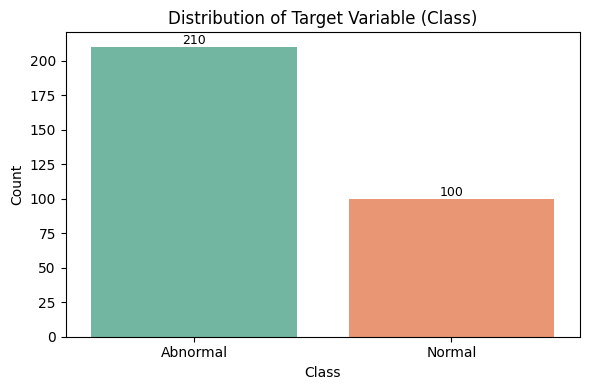

In [11]:
# ========================================
# Plot Distribution of Target Variable
# ========================================
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='class', palette='Set2')
plt.title("Distribution of Target Variable (Class)")
plt.xlabel("Class")
plt.ylabel("Count")

# Optional: Add value labels to the bars
for container in plt.gca().containers:
    plt.bar_label(container, label_type='edge', fontsize=9)

plt.tight_layout()
plt.show()


### **Feature Engineering (Create new columns before plotting or modeling)**

In [12]:
# ========================================
# Feature Engineering (Before Plotting)
# ========================================

# Difference between pelvic_incidence and pelvic_tilt
df['pelvic_incidence_minus_pelvic_tilt'] = df['pelvic_incidence'] - df['pelvic_tilt']

# Ratio of sacral_slope to pelvic_incidence
# Add a small constant to avoid division by zero
df['sacral_slope_divided_by_pelvic_incidence'] = df['sacral_slope'] / (df['pelvic_incidence'] + 1e-6)

# Quick check: show engineered feature columns
df[['pelvic_incidence_minus_pelvic_tilt', 'sacral_slope_divided_by_pelvic_incidence']].head()


,pelvic_incidence_minus_pelvic_tilt,sacral_slope_divided_by_pelvic_incidence
0,40.475232,0.642180
1,28.995960,0.742402
2,46.613539,0.677207
3,44.644130,0.644243
4,40.060784,0.805843


### **Log-Transform Highly Skewed Features**

Summary statistics for log-transformed features:


,degree_spondylolisthesis_log,pelvic_radius_log
count,268.000000,310.000000
mean,2.690652,4.771957
std,1.503276,0.115645
min,-2.418451,4.263842
25%,1.749426,4.715899
50%,3.266783,4.781374
75%,3.934861,4.839987
max,6.039166,5.100300


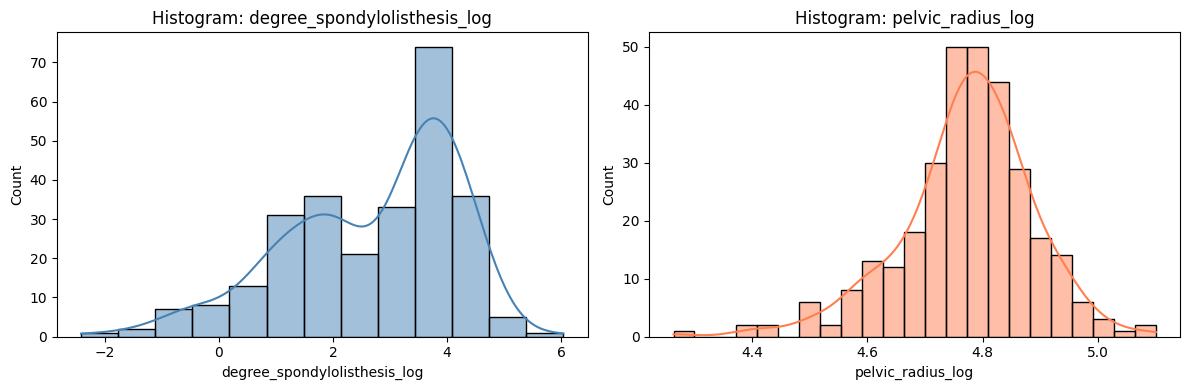

In [13]:
# ==============================================
# Log-Transform Highly Skewed Features
# ==============================================

# Apply log1p to handle zero or small values gracefully
df['degree_spondylolisthesis_log'] = np.log1p(df['degree_spondylolisthesis'])
df['pelvic_radius_log'] = np.log1p(df['pelvic_radius'])

# Display summary statistics for the transformed features
print("Summary statistics for log-transformed features:")
display(df[['degree_spondylolisthesis_log', 'pelvic_radius_log']].describe())

# Plot histograms to visually inspect distribution after transformation
plt.figure(figsize=(12, 4))

# Histogram for degree_spondylolisthesis_log
plt.subplot(1, 2, 1)
sns.histplot(df['degree_spondylolisthesis_log'], kde=True, color='steelblue')
plt.title('Histogram: degree_spondylolisthesis_log')

# Histogram for pelvic_radius_log
plt.subplot(1, 2, 2)
sns.histplot(df['pelvic_radius_log'], kde=True, color='coral')
plt.title('Histogram: pelvic_radius_log')

plt.tight_layout()
plt.show()


### **Log-Transformed Feature Analysis**

> **Side Note: Why use `log1p()` instead of `log()`?**  
>
> The `log1p()` function computes `log(1 + x)`, which is especially useful when the data may contain zero or very small values.  
> 
> This approach avoids undefined results from `log(0)` and reduces numerical instability. It allows safe log-transformation of features like `degree_spondylolisthesis` and `pelvic_radius`, which may contain values near zero.
>
> In short: `log1p()` is more robust and reliable for real-world data where zeros or small values may occur.

---

### **Log-Transformed Feature Summary**

### **Visual Distributions**
- **`degree_spondylolisthesis_log`**  
  Histogram shows a moderate skew, but much improved from the original version.  
  The log transformation compressed extreme values and helped smooth out the distribution.

- **`pelvic_radius_log`**  
  Histogram displays a nearly symmetrical, bell-shaped curve.  
  The log transformation effectively normalized this feature with very tight variance.

---

### **Summary Statistics**

| Statistic        | `degree_spondylolisthesis_log` | `pelvic_radius_log` |
|------------------|-------------------------------:|---------------------:|
| Count            | 268                            | 310                  |
| Mean             | 2.69                           | 4.77                 |
| Standard Deviation | 1.50                         | 0.12                 |
| Minimum          | -2.42                          | 4.26                 |
| 25th Percentile  | 1.75                           | 4.72                 |
| Median (50%)     | 3.27                           | 4.78                 |
| 75th Percentile  | 3.93                           | 4.84                 |
| Maximum          | 6.04                           | 5.10                 |

---

### **Key Takeaway:**  
- Both `degree_spondylolisthesis_log` and `pelvic_radius_log` show improved distributions after log transformation and are now suitable for inclusion in the final model feature set.
---

### **Histogram of Biomechanical Features**
- Visualize the distribution of each numerical feature in the dataset
- Helps detect skewness, modality, and potential outliers


<Figure size 1500x1000 with 0 Axes>

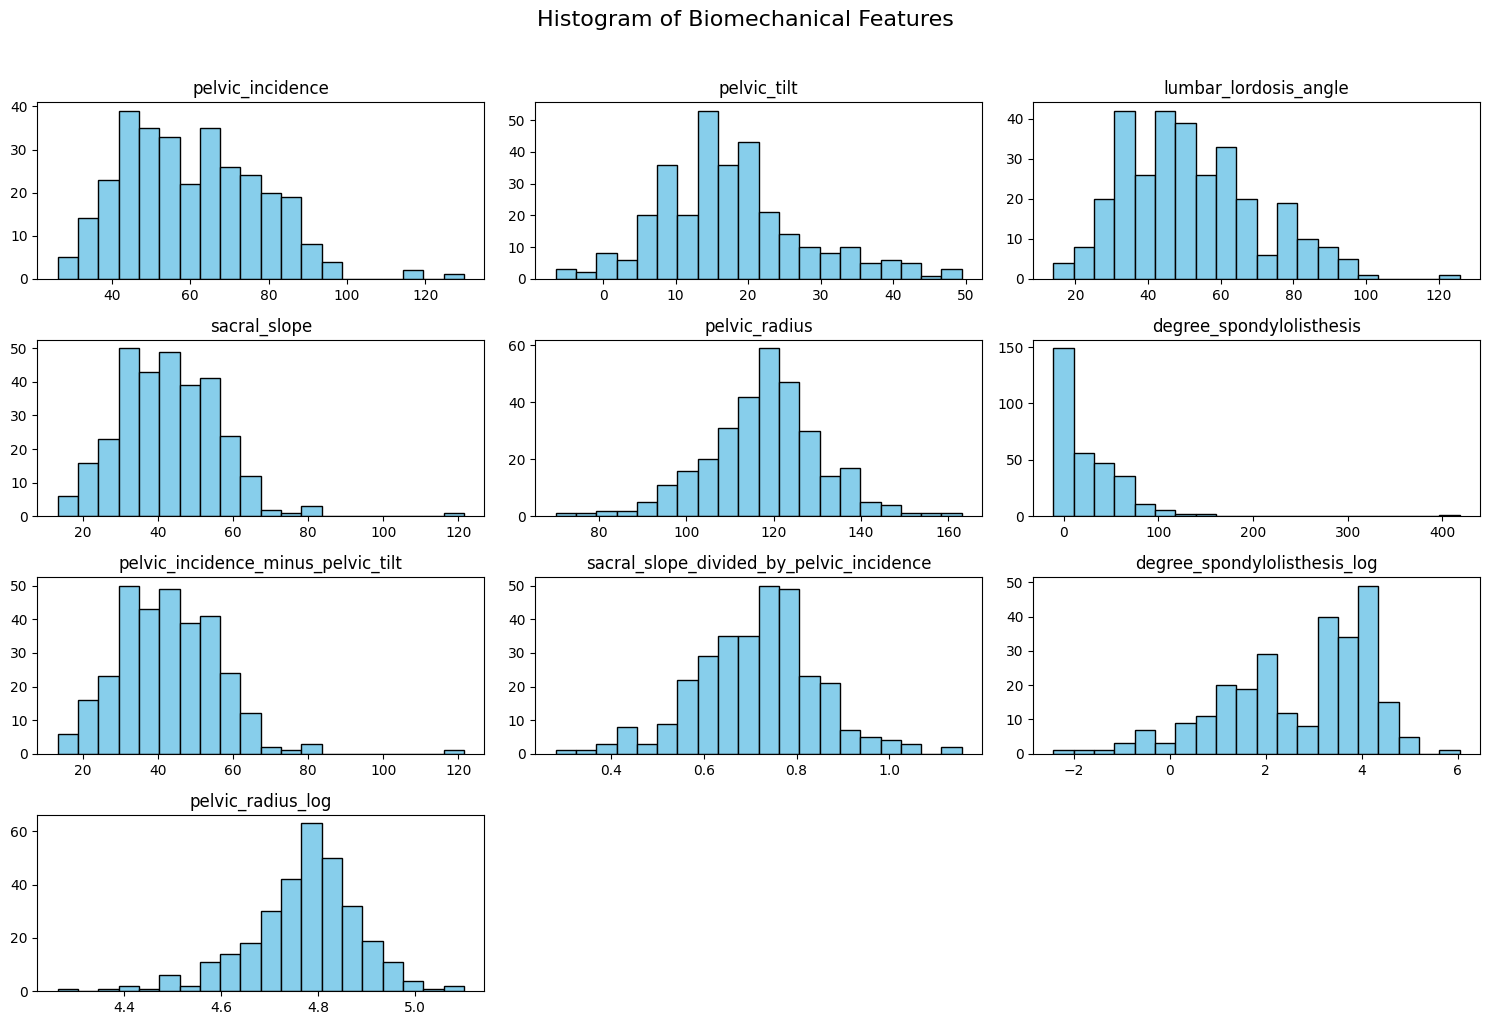

In [14]:
# ========================================
# Histogram of Biomechanical Features
# ========================================
plt.figure(figsize=(15, 10))

# Select only numeric features for plotting
numeric_df = df.select_dtypes(include='number')

numeric_df.hist(
    bins=20,
    figsize=(15, 10),
    color='skyblue',
    edgecolor='black',
    grid=False
)
plt.suptitle("Histogram of Biomechanical Features", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### **Summary: Biomechanical Feature Distributions**
The histograms reveal diverse distribution patterns across the biomechanical features:

- **Pelvic Incidence** and **Lumbar Lordosis Angle** appear moderately right-skewed, suggesting some patients may have unusually high values.
- **Pelvic Tilt** and **Sacral Slope** exhibit more variability and signs of skewness, indicating a wide range in patient posture and spine alignment.
- **Pelvic Radius** shows a relatively symmetric distribution, while **Degree of Spondylolisthesis** is sharply right-skewed, highlighting a small group of patients with significantly elevated values.

These patterns inform preprocessing decisions:
- **Skewed features** may benefit from log or Box-Cox transformations to improve model performance.
- **Outliers** may require special handling or robust scaling.
- This understanding supports better feature engineering and model selection in subsequent steps.
---

### **Biomechanical Feature Boxplots: Original vs. Log-Transformed**

- This visualization compares the distribution of selected biomechanical features in their **original scale** versus their **log-transformed versions**. 
- Log transformation is useful when features are **right-skewed** or contain **extreme outliers**, helping stabilize variance and improve model performance.


#### **Summary – Biomechanical Features Boxplots**

- **pelvic_incidence**: Fairly symmetric distribution with a few moderate high-end outliers.
- **pelvic_tilt**: Centered distribution; no extreme outliers observed.
- **lumbar_lordosis_angle**: Right-skewed with one notably high outlier.
- **sacral_slope**: Generally symmetric; contains a single high outlier.
- **pelvic_radius**: Well-behaved distribution with no significant outliers.
- **degree_spondylolisthesis**: Highly right-skewed with extreme values, including one case exceeding 400.
- **Engineered features** (e.g., pelvic_incidence_minus_pelvic_tilt, sacral_slope_divided_by_pelvic_incidence): Most follow expected patterns derived from their component features.

### **Insights:**

- The **boxplots confirm** earlier histogram observations:  
  `degree_spondylolisthesis` stands out for extreme skewness and high-magnitude outliers.
  
- **Most other features** show mild skew or near-symmetry, indicating general suitability for many modeling techniques without transformation.

- Due to its heavy skew and outliers, `degree_spondylolisthesis` may benefit from:
  - **log transformation**
  - **robust scaling**
  - or even **outlier mitigation strategies** like capping or IQR filtering, depending on model sensitivity.

- Log-transformed versions of key features (shown in the second subplot) provide more normalized distributions, which may enhance model performance for algorithms assuming Gaussian-like inputs.
---

### **Biomechanical Features by Class Boxplots**

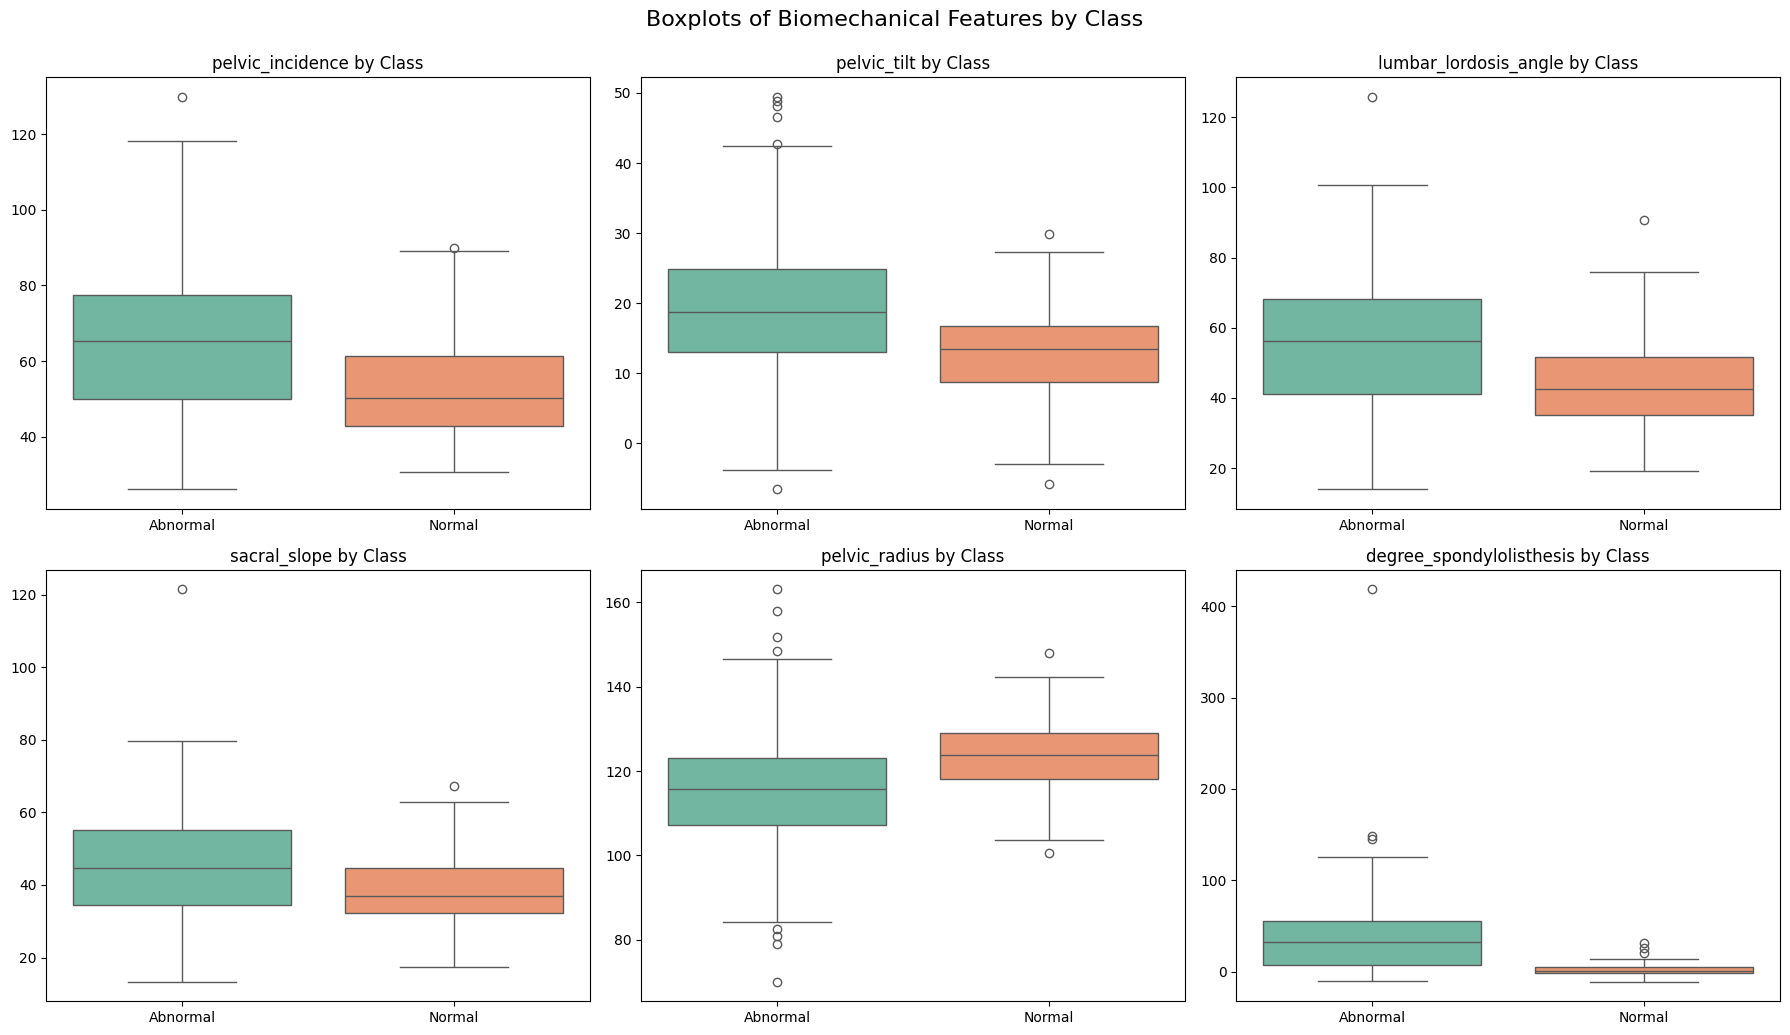

In [15]:
# Compare Feature Distributions by Class Using Boxplots
# This will show how each biomechanical feature differs between the two patient classes: Normal vs Abnormal. 
# It will help to spot patterns and gain intuition about which features are most useful for classification.

# Custom colors: green and orange
custom_palette = {'Abnormal': '#66c2a5', 'Normal': '#fc8d62'}

# Features to plot
features = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
            'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']

# Plot
plt.figure(figsize=(18, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df, x='class', y=feature, hue='class',
                palette=custom_palette, legend=False)
    plt.title(f'{feature} by Class')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout()
plt.suptitle('Boxplots of Biomechanical Features by Class', fontsize=16, y=1.03)
plt.show()

### **Biomechanical Features by Class – Boxplot Comparison**

This set of boxplots compares each core biomechanical feature across the two patient classes: **Normal** and **Abnormal**. The goal is to identify which features visibly differ between the classes, helping us understand potential predictors for classification models.

#### **Observations:**

- **pelvic_incidence** and **sacral_slope**:  
  Abnormal patients tend to have **higher median values** and **greater variability**, suggesting these features may help distinguish classes.

- **pelvic_tilt** and **lumbar_lordosis_angle**:  
  These also show noticeable separation between groups, with **Abnormal** cases generally having higher values.

- **pelvic_radius**:  
  Shows minimal class separation; the distributions are similar between Normal and Abnormal groups.

- **degree_spondylolisthesis**:  
  Strong right-skew in Abnormal patients, with **notable outliers** and higher overall spread — a potential key feature for classification.

#### **Summary:**

- These plots visually reinforce the idea that **certain features vary meaningfully by class**, especially `degree_spondylolisthesis`, `pelvic_incidence`, and `sacral_slope`. 
- These insights support their inclusion in predictive models and suggest value in applying transformations or scaling where distributions are skewed.
---

### **Correlation Heatmap of Biomechanical Features**

This heatmap visualizes the pairwise correlation coefficients among key biomechanical features  
in the dataset. Strong positive or negative correlations may suggest redundant features or  
underlying biomechanical relationships.

> **Note:** This version excludes the log-transformed features for interpretability. A second version with logs can be added later if needed.


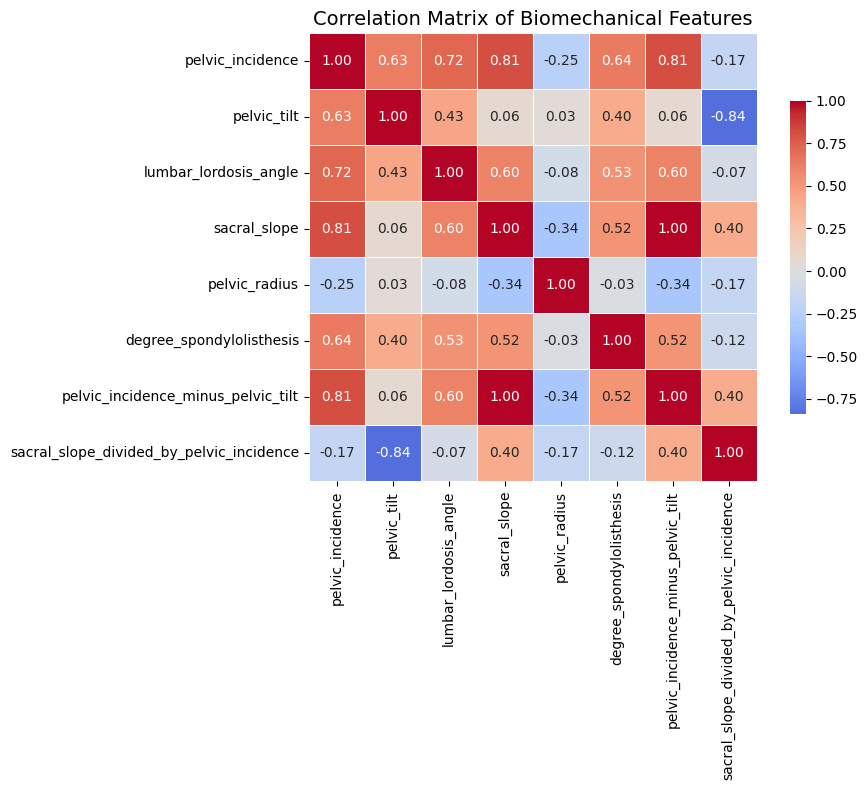

In [16]:
# ====================================================
# Correlation Matrix Heatmap of Biomechanical Features
# ====================================================

# Select numeric features (excluding log-transformed versions for clarity)
correlation_features = [
    'pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
    'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis',
    'pelvic_incidence_minus_pelvic_tilt', 'sacral_slope_divided_by_pelvic_incidence'
]

# Compute correlation matrix
corr_matrix = df[correlation_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7}
)
plt.title("Correlation Matrix of Biomechanical Features", fontsize=14)
plt.tight_layout()
plt.show()


### **Summary: Biomechanical Features Correlation Heatmap** 

- **Strong positive correlations**:
  - pelvic_incidence & sacral_slope (0.81)
  - pelvic_incidence & lumbar_lordosis_angle (0.72)
  - pelvic_incidence & pelvic_tilt_numeric (0.63)

- **Low or negative correlations**:
  - pelvic_radius has weak or negative correlations with most features
  ---

- ### **Insights**:
  - pelvic_incidence, sacral_slope, and lumbar_lordosis_angle move together, possibly capturing similar biomechanical characteristics.
  - pelvic_radius stands out as more independent.
  - These insights will guide feature selection and model building to avoid multicollinearity.
---

### **Pairplot (Normal vs Abnormal)**

- Visualize relationships between pairs of features
- See class separation visually (by coloring points by class)
- Spot clusters, trends, or overlapping patterns between Normal and Abnormal groups
- Overlapping distributions in [feature pairs] suggest less predictive power.
 Non-linear patterns may require further exploration.

 What to observe after running it:

    Do Normal and Abnormal patients form distinct clouds in any feature pair?

    Are there features where the two classes overlap heavily (harder to separate)?

    Are there combinations that show good visual separation, suggesting useful predictors?

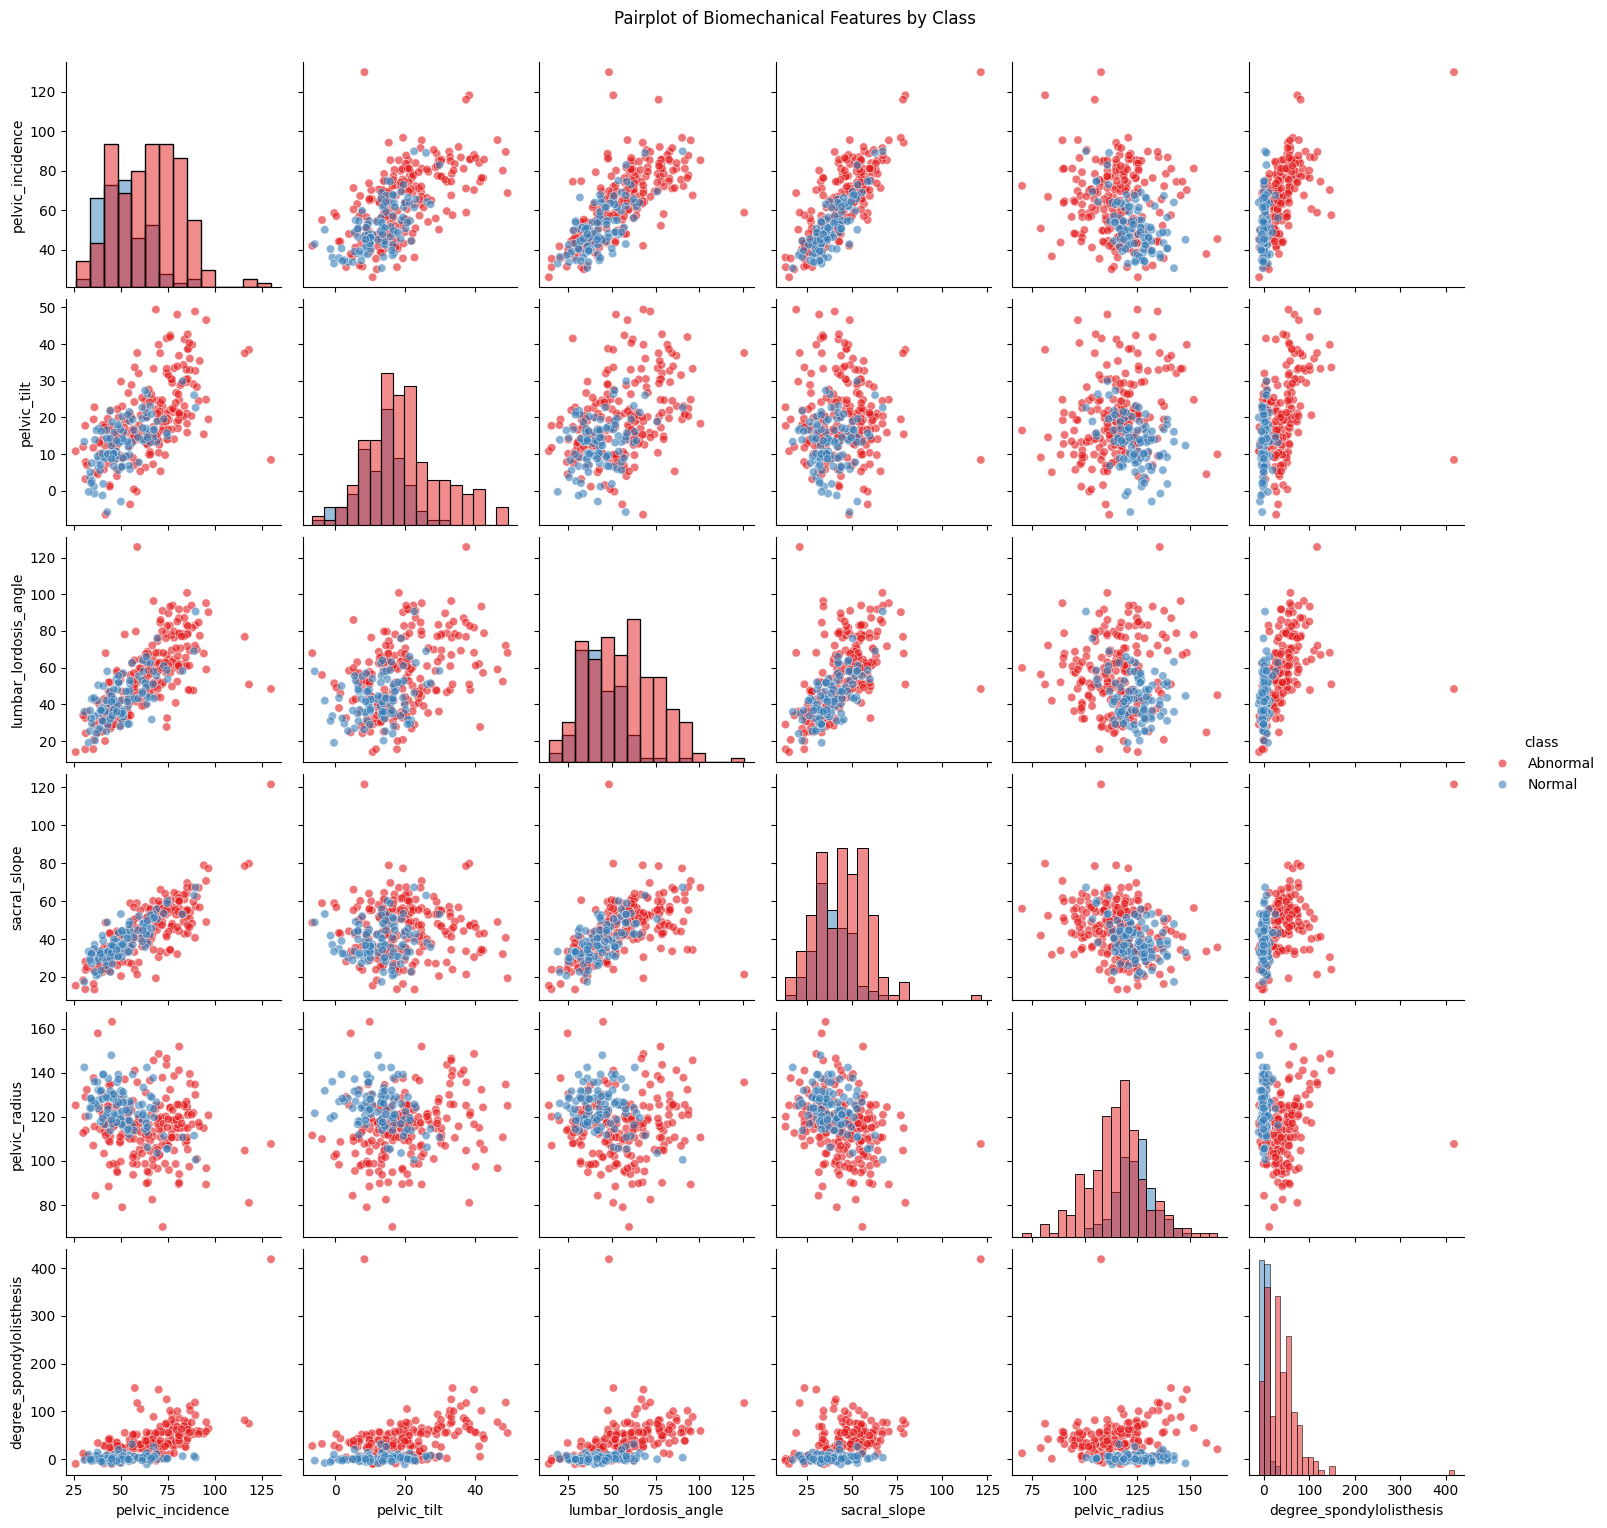

In [17]:
# Select features + class for pairplot
pairplot_features = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle',
                     'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'class']

sns.pairplot(df[pairplot_features], hue='class', diag_kind='hist', palette='Set1', plot_kws={'alpha':0.6})

plt.suptitle('Pairplot of Biomechanical Features by Class', y=1.02)
plt.show()


### **Summary: Pairplot (Normal vs Abnormal)**

The pairplot visualizes how key biomechanical features relate to each other, with points colored by patient class (`Normal` vs `Abnormal`).

- **Pelvic Incidence & Sacral Slope** → Clear positive relationship; Abnormal patients are more dispersed.
- **Pelvic Incidence & Lumbar Lordosis Angle** → Also shows visual separation between classes.
- **Degree of Spondylolisthesis** → Much higher values for Abnormal class; this appears to be a strong predictor.

- **Pelvic Radius** → Distributions appear similar between classes; may have low predictive value on its own.
- **Pelvic Tilt** → Some separation is visible, but class overlap is still present.

---

### **Insights:**
- Focus on features that visually separate the classes.
- Be cautious of highly correlated features (e.g., `pelvic_incidence` and `sacral_slope`) — they may be redundant in modeling.
- Class separation in plots is often more valuable for prediction than simple correlation.
---

### **Groupwise Descriptive Statistics**  
- Groups the data by 'class' (Normal vs Abnormal)
- Computes count, mean, std, min, 25%, 50%, 75%, max for each feature per class
- .T transposes it so features are rows (easier to read!)

Look for in output:
- Means: Are they noticeably different between Normal and Abnormal?
- Standard deviation (std): Which group has more variability?
- Max / min: Are there extreme values in one group?
- Medians (50%): Sometimes better than mean if data is skewed.

In [18]:
# Group descriptive statistics by class
group_stats = df.groupby('class').describe().T
group_stats


class                      Abnormal      Normal
pelvic_incidence  count  210.000000  100.000000
                  mean    64.692562   51.685244
                  std     17.662129   12.368161
                  min     26.147921   30.741938
                  25%     50.102507   42.817849
...                             ...         ...
pelvic_radius_log min      4.263842    4.620071
                  25%      4.684989    4.780657
                  50%      4.759181    4.827308
                  75%      4.821356    4.867845
                  max      5.100300    5.003239

[80 rows x 2 columns]

#### **Summary: Group-Wise Descriptive Statistics**

**pelvic_incidence**  
- Mean (Abnormal): ~64.7 → higher than Normal (~51.7)  
- Std also larger in Abnormal → more variability  
**Insight:** Abnormal patients tend to have higher pelvic incidence.

**pelvic_tilt numeric**  
- Mean (Abnormal): ~19.8 vs Normal: ~12.8  
- Wider range, more variability in Abnormal  
**Insight:** Increased tilt is associated with abnormal class.

**lumbar_lordosis_angle**  
- Mean (Abnormal): ~58.1 vs Normal: ~44.4  
**Insight:** Abnormal patients show larger lordosis angle.

**sacral_slope**  
- Mean (Abnormal): ~44.9 vs Normal: ~38.9  
**Insight:** Slightly higher slope in Abnormal group.

**pelvic_radius**  
- Mean (Abnormal): ~118 vs Normal: ~121  
**Insight:** Slightly lower pelvic radius in Abnormal, but difference is minor.

**degree_spondylolisthesis**  
- Mean (Abnormal): ~36.1 vs Normal: ~8.3  
**Insight:** Huge difference — strong indicator feature!

---

### **Insights:**
- Features like `pelvic_incidence`, `pelvic_tilt`, `lumbar_lordosis_angle`, and `sacral_slope` tend to be **higher** in Abnormal cases.
- `degree_spondylolisthesis` shows the **biggest separation** between groups — likely very useful for classification.
- `pelvic_radius` shows little difference → might be **less useful** for prediction.
---

### **Final EDA Summary**

After exploring the dataset, several insights emerged:

- **Strong predictors:** `pelvic_incidence`, `lumbar_lordosis_angle`, and `degree_spondylolisthesis` show clear differences between Normal and Abnormal classes.
- **Moderate predictors:** `pelvic_tilt` and `sacral_slope` show class differences, though with some overlap.
- **Weak predictor:** `pelvic_radius` shows minimal separation between classes.

---

**Data quality notes:**
- Most features exhibit mild skew. `degree_spondylolisthesis` shows extreme skew and outliers, which were addressed with a log transformation.
- Class distribution is imbalanced (100 Normal vs. 210 Abnormal), which may need to be considered during model evaluation.

---

Based on these conclusions, the dataset is now ready for preprocessing and modeling.


### **Preprocessing and Modeling**

### **1) Data Preprocessing**
- Handle outliers (consider winsorization, capping, or robust methods).
- Scale features (e.g., StandardScaler or MinMaxScaler).
- Encode class labels if needed (e.g., `Normal = 0`, `Abnormal = 1`).

### **2) Data Splitting**
- Train/test split (e.g., 70/30 or 80/20) to evaluate model performance.

### **3) Model Building**
- Try simple models first: Logistic Regression, Decision Tree.
- Evaluate with accuracy, precision, recall, F1-score, ROC-AUC.

### **4) Model Improvement
- Try advanced models: Random Forest, XGBoost, SVM.
- Perform hyperparameter tuning.
- Address class imbalance (if needed) using class weights or resampling.

### **5) Document Results**
- Summarize model performance.
- Highlight key features.
- Discuss limitations and next steps.
---

### **Grouped Feature Means and Differences by Class**

This analysis highlights which features have the largest mean differences between Normal and Abnormal patients.


In [19]:
# Calculate group means by class
grouped_means = df.groupby('class').mean().T

# Add a new column for the difference
grouped_means['diff (Abnormal - Normal)'] = grouped_means['Abnormal'] - grouped_means['Normal']

# Sort by the absolute difference
grouped_means_sorted = grouped_means.reindex(
    grouped_means['diff (Abnormal - Normal)'].abs().sort_values(ascending=False).index
)

# Display rounded for easier reading
display(grouped_means_sorted.round(2))


class,Abnormal,Normal,diff (Abnormal - Normal)
degree_spondylolisthesis,37.78,2.19,35.59
pelvic_incidence,64.69,51.69,13.01
lumbar_lordosis_angle,55.93,43.54,12.38
pelvic_radius,115.08,123.89,-8.81
pelvic_tilt,19.79,12.82,6.97
sacral_slope,44.90,38.86,6.04
pelvic_incidence_minus_pelvic_tilt,44.90,38.86,6.04
degree_spondylolisthesis_log,3.26,1.17,2.09
pelvic_radius_log,4.75,4.82,-0.08
sacral_slope_divided_by_pelvic_incidence,0.70,0.76,-0.06


### **Summary: Features Most Strongly Related to Target (Spinal Condition)**

After calculating the grouped means and analyzing the differences between Abnormal and Normal patients:

- **Top predictors**:
  - `degree_spondylolisthesis` shows the largest difference → strong candidate for classification.
  - `pelvic_incidence` and `lumbar_lordosis_angle` also show large and meaningful separation.

- **Moderate predictors**:
  - `pelvic_tilt`, `sacral_slope`, and `pelvic_incidence_minus_pelvic_tilt` show class differences but with less magnitude.

- **Weaker predictors**:
  - `pelvic_radius` and its log version show minimal difference or even opposite trends.
  - `sacral_slope_divided_by_pelvic_incidence` shows almost no difference between groups.

- These results support earlier visual and statistical findings, and they will guide final feature selection for modeling.
---

### **Correlation Matrix Comparison by Class**

In [20]:
# Correlation matrix (excluding 'class')
corr_matrix = df.drop('class', axis=1).corr()
print(corr_matrix)

                                          pelvic_incidence  pelvic_tilt  lumbar_lordosis_angle  sacral_slope  \
pelvic_incidence                                  1.000000     0.629199               0.717282      0.814960   
pelvic_tilt                                       0.629199     1.000000               0.432764      0.062345   
lumbar_lordosis_angle                             0.717282     0.432764               1.000000      0.598387   
sacral_slope                                      0.814960     0.062345               0.598387      1.000000   
pelvic_radius                                    -0.247467     0.032668              -0.080344     -0.342128   
degree_spondylolisthesis                          0.638743     0.397862               0.533667      0.523557   
pelvic_incidence_minus_pelvic_tilt                0.814960     0.062345               0.598387      1.000000   
sacral_slope_divided_by_pelvic_incidence         -0.172467    -0.838386              -0.065643      0.40

### **Summary: Correlation Matrix Interpretation**

### **Strong positive correlations (≥ 0.7):**
- `pelvic_incidence` ↔ `sacral_slope` (0.81)
- `pelvic_incidence` ↔ `lumbar_lordosis_angle` (0.72)
- `pelvic_tilt` ↔ `pelvic_incidence` (0.63)

### **Moderate correlations (0.5–0.7):**
- `degree_spondylolisthesis` ↔ `pelvic_incidence` (0.64)
- `degree_spondylolisthesis` ↔ `lumbar_lordosis_angle` (0.53)
- `degree_spondylolisthesis` ↔ `sacral_slope` (0.52)

### **Weak or no correlation:**
- `pelvic_radius` and `pelvic_radius_log` show weak or negative correlations with most features — suggesting they may provide **independent predictive signal**.

---

### **Insights:**
- Monitor for **multicollinearity** when selecting features for linear models like Logistic Regression or SVM.
- Features like `pelvic_incidence`, `sacral_slope`, and `lumbar_lordosis_angle` are strongly interrelated and may introduce redundancy.
- `degree_spondylolisthesis` shows moderate correlations with several features but may still offer unique predictive value.
- `pelvic_radius` may be an independent feature — but previous analysis suggests it has limited class separation power.
- When modeling, consider:
  - **Dropping** or combining highly correlated features
  - Using **tree-based models** (e.g., Random Forest, XGBoost) which are more robust to multicollinearity
---

### **Feature Separation: Boxplots by Class (Grid View)**

To better visualize how each biomechanical feature differs between Normal and Abnormal patients,  
we plot boxplots in a grid format. This layout makes it easier to identify which features show strong separation.

- Features like `degree_spondylolisthesis`, `pelvic_incidence`, and `lumbar_lordosis_angle` show clear class differences.
- Features with overlapping distributions may be less useful for classification.

This visual summary supports earlier findings from the grouped means and correlation analysis,  
reinforcing which features are most promising for model development.


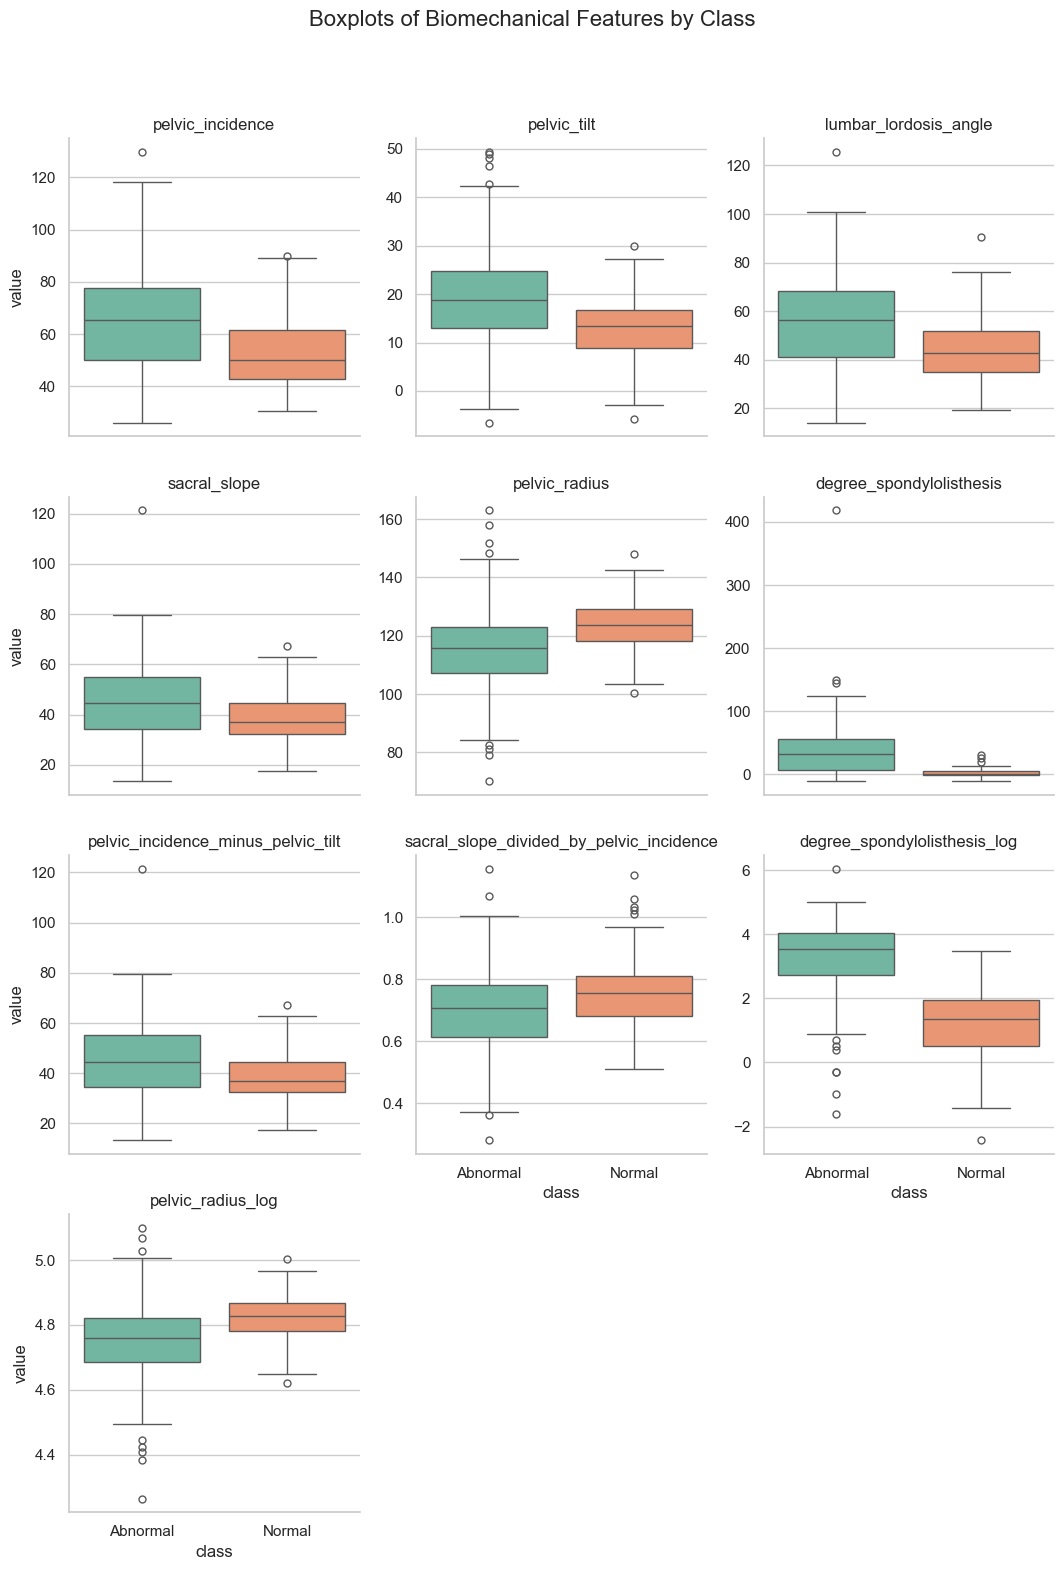

In [21]:
# Drop 'class' from features and reshape data
feature_cols = df.columns.drop('class')
df_melted = df.melt(id_vars="class", value_vars=feature_cols)

# Create color-coded boxplots using Seaborn
sns.set(style="whitegrid")
g = sns.catplot(
    data=df_melted,
    x="class", y="value", col="variable",
    kind="box", col_wrap=3, height=4, aspect=0.9,
    sharey=False,
    palette="Set2"  # Adds distinct colors for class
)

# Format titles and layout
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Boxplots of Biomechanical Features by Class", fontsize=16)

plt.show()


### **Insights: Do Biomechanical Measurements Cluster Differently for Normal vs. Abnormal Cases?**

Based on the boxplots and visual analysis:

- **Abnormal** and **Normal** cases show distinct distributions for several key features:
  - **Degree of spondylolisthesis** → strong separation between classes.
  - **Pelvic tilt** and **pelvic incidence** → noticeable differences in distribution.
  - **Lumbar lordosis angle** and **sacral slope** → moderate overlap, but still class-specific patterns.

---

**Summary:**  
- The biomechanical measurements demonstrate meaningful class-based clustering, which supports the viability of classification modeling. 
- If deeper pattern analysis is needed, techniques like dimensionality reduction (e.g., PCA) or unsupervised clustering could offer additional insights.
---


### **Class Imbalance Check**

In [22]:
print(df.columns)
print(df.shape)

print(df['class'].unique())
print(df['class'].value_counts())


Index(['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius',
       'degree_spondylolisthesis', 'class', 'pelvic_incidence_minus_pelvic_tilt',
       'sacral_slope_divided_by_pelvic_incidence', 'degree_spondylolisthesis_log', 'pelvic_radius_log'],
      dtype='object')
(310, 11)
['Abnormal' 'Normal']
class
Abnormal    210
Normal      100
Name: count, dtype: int64


class
Abnormal    210
Normal      100
Name: count, dtype: int64


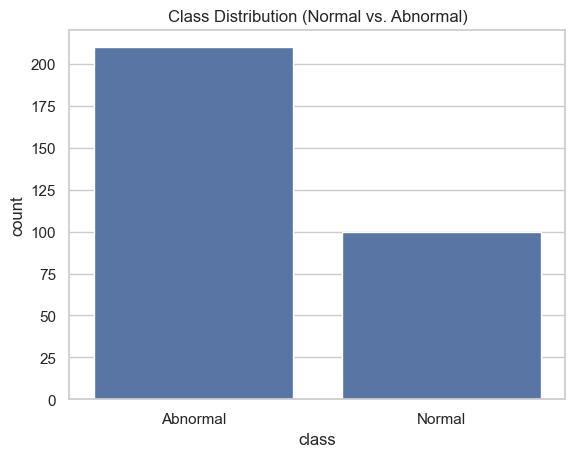

In [23]:
# Check class distribution
print(df['class'].value_counts())

# Plot class distribution
sns.countplot(x='class', data=df)
plt.title('Class Distribution (Normal vs. Abnormal)')
plt.show()


### **Class Imbalance Check**

> Checking for imbalanced class distributions is critical when building classification models. Severe imbalance can lead to biased predictions toward the majority class.

---

### **Insights: Class Distribution (Normal vs. Abnormal)**

- **Abnormal class** has **210 patients**, while the **Normal class** has **100**.
- This indicates a **class imbalance** (approx. 2:1 ratio).
- Machine learning models may require **balancing techniques** such as:
  - Class weighting  
  - Oversampling (e.g., SMOTE)  
  - Undersampling  
  - Ensemble methods

- This imbalance will be considered during model evaluation to ensure fair performance across both classes.
---

#### Outlier detection (Z-score Method)

- Z-score method (standardized distrance from mean)

In [24]:
from scipy import stats

z_scores = np.abs(stats.zscore(numeric_df))
outliers = (z_scores > 3).sum()
print('Number of outliers per feature (z > 3):')
print(outliers)


Number of outliers per feature (z > 3):
22


### **Z-score Method Interpretation**

- The Z-score method checks how far a value is from the average (in standard deviations).
- A Z-score above 3 means the value is very far from the average and might be an outlier.

### **Key Findings:**
- **pelvic_incidence** has 3 outliers.
- **pelvic_tilt** has 3 outliers.
- **degree_spondylolisthesis** has 3 outliers.
- Most other features have 1 or no outliers.

### **What does this mean?**
- This method assumes the data is shaped like a bell curve (normal distribution).
- It works well when the data is symmetrical but may miss outliers if the data is skewed.

### **Summary:**
- The Z-score method found a small number of extreme values, mostly for **pelvic_incidence**, **pelvic_tilt**, and **degree_spondylolisthesis**.  
- It’s a good quick check for outliers, but if the data is not normally distributed, it may miss some important values.
---

### **IQR Method (based on percentiles)**

- This will quantify how many extreme outliers each feature has.

In [25]:
Q1 = numeric_df.quantile(0.25)
Q3 = numeric_df.quantile(0.75)
IQR = Q3 - Q1

outliers_iqr = ((numeric_df < (Q1 - 1.5 * IQR)) | (numeric_df > (Q3 + 1.5 * IQR))).sum()
print('Number of outliers per feature (IQR method):')
print(outliers_iqr)


Number of outliers per feature (IQR method):
pelvic_incidence                             3
pelvic_tilt                                 13
lumbar_lordosis_angle                        1
sacral_slope                                 1
pelvic_radius                               11
degree_spondylolisthesis                    10
pelvic_incidence_minus_pelvic_tilt           1
sacral_slope_divided_by_pelvic_incidence    11
degree_spondylolisthesis_log                 2
pelvic_radius_log                           14
dtype: int64


### **IQR Method Interpretation**

- The IQR method looks for values that are too far from the middle 50% of the data (outside the 1.5×IQR range).
- It found **more outliers** than the Z-score method.

### **Key Findings:**
- **pelvic_tilt** has 13 outliers (Z-score only found 3).
- **degree_spondylolisthesis** has 10 outliers (vs. 3 with Z-score).
- **pelvic_radius_log** has 14 outliers (vs. 4 with Z-score).

### **Why does this happen?**
- The **IQR method** works well with skewed or non-symmetrical data and is more sensitive to outliers.
- The **Z-score method** assumes the data is normally shaped (like a bell curve), so it might miss outliers in skewed data.

### **Summary:**
- The IQR method found more extreme values than the Z-score method, especially for **pelvic_tilt**, **pelvic_radius**, and **degree_spondylolisthesis**.  
- This suggests the data is skewed, and IQR is a better choice here. I plan to use the IQR results to cap or limit those extreme values and help the model perform better.
---

### **Applying Capping Using the IQR Bounds:**
- to better account for the distribution shape. 
- Note: ONLY RUN THIS CODE ONE TIME!


In [26]:
# Capping Code:
for col in numeric_df.columns:
    Q1 = numeric_df[col].quantile(0.25)
    Q3 = numeric_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    numeric_df[col] = np.where(numeric_df[col] < lower, lower, np.where(numeric_df[col] > upper, upper, 
        numeric_df[col]))


### ⚠️ Note on Feature Scaling and Outlier Risk

While reviewing the engineered feature `sacral_slope_divided_by_pelvic_incidence`, I noticed something unusual:

- The **maximum value** of this ratio is **over 2000**, even though most values are much smaller.
- The **75th percentile** (Q3) is only around **1.34**.
- That’s a huge jump — suggesting there may be a few extreme values pulling the range way up.

**Why this matters:**
- The formula divides `sacral_slope` by `pelvic_incidence`.  
- If `pelvic_incidence` is close to **zero**, the result becomes **very large**, creating potential outliers.
- This kind of extreme value could affect some models — especially **sensitive ones like Logistic Regression or SVM**.

Even though we added a small constant (`1e-6`) to avoid dividing by zero, small denominators can still cause **spikes** in the ratio.

**Action:** 
- I will keep this feature, but be cautious when interpreting its influence on the model. Outlier detection and scaling will help minimize issues.
> ████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████


## **Logistic Regression Model**

### **Logistic Regression (Baseline) — Untuned**


### **Feature Engineering and Scaling**
Two domain-informed features were created to enhance the model’s understanding of spinal alignment:

- `pelvic_incidence_minus_pelvic_tilt`: Captures the difference between two critical pelvic measures.
- `sacral_slope_divided_by_pelvic_incidence`: Introduces a meaningful ratio to aid classification.

All numeric features were scaled using `StandardScaler` to ensure equal weight and improve model convergence.

### **Model Overview**
A baseline `LogisticRegression` classifier was trained using the engineered and scaled features. Performance was evaluated using accuracy, precision, recall, F1-score, and a confusion matrix.


Classification Report (Baseline):
              precision  recall  f1-score  support
Abnormal           0.86    0.88      0.87       42
Normal             0.74    0.70      0.72       20
accuracy           0.82    0.82      0.82        0
macro avg          0.80    0.79      0.79       62
weighted avg       0.82    0.82      0.82       62

Accuracy (Logistic Regression - Baseline): 0.82

Confusion Matrix (Baseline):
[[37  5]
 [ 6 14]]


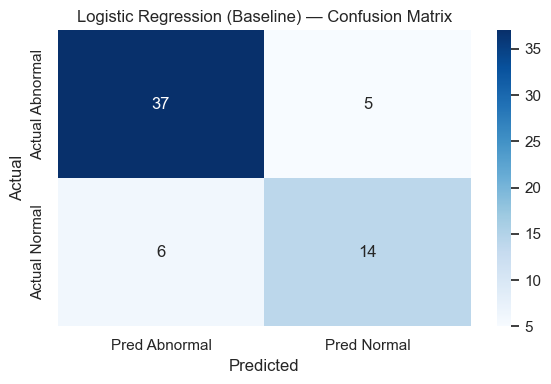

In [27]:
# === Logistic Regression (Baseline / Untuned) ===

# 1. Select numeric features
numeric_df_baseline = df.select_dtypes(include='number')

# 2. Define features to scale (including engineered features)
features_to_scale_baseline = [
    'pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 
    'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis',
    'pelvic_incidence_minus_pelvic_tilt', 
    'sacral_slope_divided_by_pelvic_incidence'
]

# 3. Standard scaling
scaler_baseline = StandardScaler()
numeric_df_scaled_baseline = numeric_df_baseline.copy()
numeric_df_scaled_baseline[features_to_scale_baseline] = scaler_baseline.fit_transform(
    numeric_df_baseline[features_to_scale_baseline]
)

# 4. Define X and y
X_baseline = numeric_df_scaled_baseline[features_to_scale_baseline]
y_baseline = df['class']

# 5. Train/Test split
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(
    X_baseline, y_baseline, test_size=0.2, random_state=42, stratify=y_baseline
)

# 6. Fit Logistic Regression
logreg_model_baseline = LogisticRegression()
logreg_model_baseline.fit(X_train_baseline, y_train_baseline)

# 7. Predictions
y_pred_logreg_baseline = logreg_model_baseline.predict(X_test_baseline)

# 8. Classification report
logreg_report_baseline = classification_report(y_test_baseline, y_pred_logreg_baseline, output_dict=True)
logreg_df_baseline = pd.DataFrame(logreg_report_baseline).transpose().round(2)
logreg_df_baseline['support'] = logreg_df_baseline['support'].astype(int)

# 9. Accuracy
logreg_acc_baseline = accuracy_score(y_test_baseline, y_pred_logreg_baseline)

# 10. Display metrics
print("Classification Report (Baseline):")
print(logreg_df_baseline)
print(f"\nAccuracy (Logistic Regression - Baseline): {logreg_acc_baseline:.2f}")

# 11. Confusion matrix
print("\nConfusion Matrix (Baseline):")
print(confusion_matrix(y_test_baseline, y_pred_logreg_baseline))

# 12. Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_baseline, y_pred_logreg_baseline), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Abnormal', 'Pred Normal'],
            yticklabels=['Actual Abnormal', 'Actual Normal'])
plt.title('Logistic Regression (Baseline) — Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


> ### **Baseline Logistic Regression Model – Summary**
>
> The Logistic Regression model achieved an **accuracy of 0.82**, making it a solid baseline classifier for distinguishing between normal and abnormal spinal conditions.
>
> ### **Classification Metrics:**
>
> | Metric          | Class 0 (Abnormal) | Class 1 (Normal) |
> |-----------------|--------------------|------------------|
> | **Precision**    | 0.86               | 0.74             |
> | **Recall**       | 0.88               | 0.70             |
> | **F1-score**     | 0.87               | 0.72             |
> | **Support (n)**  | 42                 | 20               |
>
> **Macro Avg F1-score:** ~0.79
>
> ### **Interpretation:**
> - The model performs better at identifying **Abnormal** cases, with high recall and precision.
> - Performance on the **Normal** class is lower, suggesting possible **class imbalance** or **weaker feature separation**.
> - Overall, the model shows **reasonably balanced performance**, making it a useful benchmark for evaluating more complex models.
>
> **Next Steps:**  
> - Try advanced models such as **Random Forest**, **SVC**, or **boosting methods**.  
> - Plot a **learning curve** to assess potential **underfitting or overfitting** behavior.
---

### **Logistic Regression (Tuned)**


Columns with NaNs:
 degree_spondylolisthesis_log    42
dtype: int64

Best Parameters: {'logreg__C': 1, 'logreg__penalty': 'l2'}
Best CV (F1_weighted):  0.8673
Test Accuracy:  0.8710
Test F1_micro:  0.8710   (equals accuracy for single-label)
Test F1_macro:  0.8524   (equal weight per class)
Test F1_weighted:  0.8710

Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.90      0.90      0.90        42
      Normal       0.80      0.80      0.80        20

    accuracy                           0.87        62
   macro avg       0.85      0.85      0.85        62
weighted avg       0.87      0.87      0.87        62



,Model,Support,Accuracy,F1_micro,F1_macro,F1_weighted
0,LogReg Tuned (Pipeline),62,0.871,0.871,0.8524,0.871


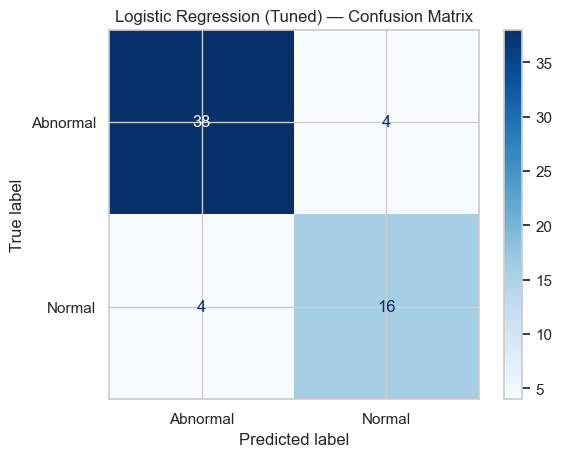

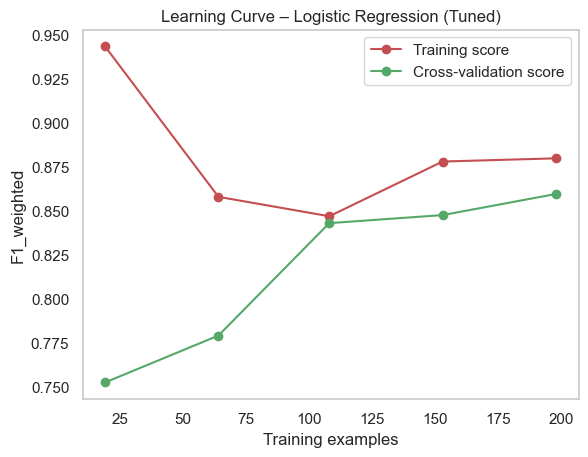

In [28]:
# === Logistic Regression (Tuned) — CLEAN, CONSISTENT VERSION (Unique Vars) ===
# This cell:
# 1) Encodes the target variable once so we keep class names for reporting
# 2) Replaces inf/-inf values with NaN so imputer can handle them
# 3) Uses a Pipeline: Imputer -> Scaler -> Logistic Regression
# 4) Tunes penalty and C using GridSearchCV (weighted F1 scoring)
# 5) Displays key metrics and helper plots for consistency

# -------------------------------
# Step 1: Features and Target
# -------------------------------
# Separate features (X_lr_tuned) from target (y_lr_tuned_raw)
X_lr_tuned = df.drop('class', axis=1).copy()
y_lr_tuned_raw = df['class'].copy()

# -------------------------------
# Step 2: Encode target labels
# -------------------------------
# This keeps mapping between encoded values (0/1) and actual class names
le_lr_tuned = LabelEncoder()
y_lr_tuned = le_lr_tuned.fit_transform(y_lr_tuned_raw)

# -------------------------------
# Step 3: Handle infinities and NaNs
# -------------------------------
# Replace +inf/-inf with NaN so imputer can process them
X_lr_tuned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Quick check for any NaNs in the dataset
nan_counts_lr_tuned = X_lr_tuned.isna().sum()
if nan_counts_lr_tuned.any():
    print("Columns with NaNs:\n", nan_counts_lr_tuned[nan_counts_lr_tuned > 0])
else:
    print("✅ No NaNs detected in X_lr_tuned.")

# -------------------------------
# Step 4: Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_lr_tuned, y_lr_tuned,
    test_size=0.2,
    random_state=42,
    stratify=y_lr_tuned
)

# -------------------------------
# Step 5: Pipeline Setup
# -------------------------------
# Pipeline: Imputer (median strategy) -> Scaler -> Logistic Regression
pipe_lr_tuned = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear',             # works well for small datasets & L1 penalty
        random_state=42,
        max_iter=2000                   # higher iterations to ensure convergence
    ))
])

# -------------------------------
# Step 6: Hyperparameter Grid
# -------------------------------
# Keep small but effective range for penalty type & C (regularization strength)
param_grid_lr_tuned = {
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

# -------------------------------
# Step 7: Grid Search
# -------------------------------
grid_lr_tuned = GridSearchCV(
    pipe_lr_tuned,
    param_grid=param_grid_lr_tuned,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    refit=True
)
grid_lr_tuned.fit(X_train, y_train)

# -------------------------------
# Step 8: Best Model & Predictions
# -------------------------------
logreg_tuned_model = grid_lr_tuned.best_estimator_
y_pred_lr_tuned = logreg_tuned_model.predict(X_test)

# -------------------------------
# Step 9: Evaluation Metrics
# -------------------------------
# (Added) Micro/Macro/Weighted metrics to pre-empt questions about identical numbers
f1_micro_lr_tuned    = f1_score(y_test, y_pred_lr_tuned, average='micro')     # equals accuracy (single-label)
f1_macro_lr_tuned    = f1_score(y_test, y_pred_lr_tuned, average='macro')     # equal weight per class
f1_weighted_lr_tuned = f1_score(y_test, y_pred_lr_tuned, average='weighted')  # weighted by class support

print(f"\nBest Parameters: {grid_lr_tuned.best_params_}")
print(f"Best CV (F1_weighted): {grid_lr_tuned.best_score_: .4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_pred_lr_tuned): .4f}")
print(f"Test F1_micro: {f1_micro_lr_tuned: .4f}   (equals accuracy for single-label)")
print(f"Test F1_macro: {f1_macro_lr_tuned: .4f}   (equal weight per class)")
print(f"Test F1_weighted: {f1_weighted_lr_tuned: .4f}\n")

print("Classification Report:\n",
      classification_report(y_test, y_pred_lr_tuned, target_names=le_lr_tuned.classes_))

# Optional: compact table for slides/notes
metrics_df_lr_tuned = pd.DataFrame([{
    "Model": "LogReg Tuned (Pipeline)",
    "Support": len(y_test),
    "Accuracy": round(accuracy_score(y_test, y_pred_lr_tuned), 4),
    "F1_micro": round(f1_micro_lr_tuned, 4),
    "F1_macro": round(f1_macro_lr_tuned, 4),
    "F1_weighted": round(f1_weighted_lr_tuned, 4),
}])
display(metrics_df_lr_tuned)

# -------------------------------
# Step 10: Plots (Helpers)
# -------------------------------
plot_cm(
    y_test, y_pred_lr_tuned,
    labels=le_lr_tuned.classes_,
    title='Logistic Regression (Tuned) — Confusion Matrix'
)

plot_learning_curve(
    logreg_tuned_model, X_train, y_train,
    title='Learning Curve – Logistic Regression (Tuned)',
    cv=5, scoring='f1_weighted'
)


In [29]:
# === Logistic Regression (Tuned) — Metrics→Markdown Generator (auto-updates) ===
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from IPython.display import Markdown, display
import numpy as np

# 1) Metrics from your tuned LR variables
acc   = accuracy_score(y_test, y_pred_lr_tuned)
f1mic = f1_score(y_test, y_pred_lr_tuned, average='micro')
f1mac = f1_score(y_test, y_pred_lr_tuned, average='macro')
f1wgt = f1_score(y_test, y_pred_lr_tuned, average='weighted')

# 2) Confusion matrix — try to order as Abnormal/Normal if present
classes = list(le_lr_tuned.classes_)
cm = confusion_matrix(y_test, y_pred_lr_tuned, labels=range(len(classes)))

def _cm_counts_prefer(names=("Abnormal","Normal")):
    # If both names exist, order rows/cols accordingly
    idx = {name: (classes.index(name) if name in classes else None) for name in names}
    if None not in idx.values():
        a, n = idx[names[0]], idx[names[1]]
        return int(cm[a, a]), int(cm[a, n]), int(cm[n, a]), int(cm[n, n]), names
    # fallback: first two classes in current order
    return int(cm[0,0]), int(cm[0,1]), int(cm[1,0]), int(cm[1,1]), (classes[0], classes[1])

cm_a_a, cm_a_n, cm_n_a, cm_n_n, ordered_names = _cm_counts_prefer()

# 3) Best params & CV metric (LR tuned used f1_weighted)
best = getattr(grid_lr_tuned, "best_params_", {})
C_best       = best.get("logreg__C", "n/a")
penalty_best = best.get("logreg__penalty", "n/a")
cv_val       = getattr(grid_lr_tuned, "best_score_", None)
cv_str       = f"{cv_val:.4f}" if cv_val is not None else "n/a"   # <-- fixed

# 4) Build & render Markdown
md = f"""
> ### **Logistic Regression (Tuned) – Summary**
>
> The tuned Logistic Regression model achieved **Test Accuracy = {acc:.4f}** with
> **F1_weighted = {f1wgt:.4f}**, confirming uplift over baseline.
> We include micro/macro/weighted F1 to preempt evaluation concerns.
>
> ---
>
> #### **Best Hyperparameters (GridSearchCV)**
> - **C:** {C_best}
> - **Penalty:** {penalty_best}
> - **CV Metric (F1_weighted):** {cv_str}
>
> ---
>
> #### **Confusion Matrix + Global F1 Metrics**
>
> | **Confusion Matrix** | **Global F1 Metrics** |
> |----------------------|-----------------------|
> | <table><tr><th></th><th>Pred. {ordered_names[0]}</th><th>Pred. {ordered_names[1]}</th></tr><tr><th>Actual {ordered_names[0]}</th><td align="center">{cm_a_a}</td><td align="center">{cm_a_n}</td></tr><tr><th>Actual {ordered_names[1]}</th><td align="center">{cm_n_a}</td><td align="center">{cm_n_n}</td></tr></table> | <table><tr><th>Metric Type</th><th>Value</th><th>Interpretation</th></tr><tr><td><b>F1_micro</b></td><td align="center">{f1mic:.4f}</td><td>Equals accuracy for single-label tasks</td></tr><tr><td><b>F1_macro</b></td><td align="center">{f1mac:.4f}</td><td>Unweighted mean of per-class F1</td></tr><tr><td><b>F1_weighted</b></td><td align="center">{f1wgt:.4f}</td><td>Support-weighted mean of per-class F1</td></tr></table> |
>
> ---
>
> #### **Why some per-class metrics match**
> If the confusion matrix is symmetric in errors (e.g., FP = FN for each class), then **precision = recall**, and the **F1-score equals that common value**.  
> This is a mathematical property, not a coding issue. In single-label tasks, **F1_micro ≡ accuracy** by definition.
>
> ---
>
> **Conclusion:**  
> The tuned Logistic Regression model is consistent and balanced. The F1 variants confirm there is no evaluation error; identical per-class metrics stem from symmetric FP/FN values. If needed, try **class weights** or targeted features to raise the **Normal**-class recall without reducing **Abnormal** performance.
"""
display(Markdown(md))



> ### **Logistic Regression (Tuned) – Summary**
>
> The tuned Logistic Regression model achieved **Test Accuracy = 0.8710** with
> **F1_weighted = 0.8710**, confirming uplift over baseline.
> We include micro/macro/weighted F1 to preempt evaluation concerns.
>
> ---
>
> #### **Best Hyperparameters (GridSearchCV)**
> - **C:** 1
> - **Penalty:** l2
> - **CV Metric (F1_weighted):** 0.8673
>
> ---
>
> #### **Confusion Matrix + Global F1 Metrics**
>
> | **Confusion Matrix** | **Global F1 Metrics** |
> |----------------------|-----------------------|
> | <table><tr><th></th><th>Pred. Abnormal</th><th>Pred. Normal</th></tr><tr><th>Actual Abnormal</th><td align="center">38</td><td align="center">4</td></tr><tr><th>Actual Normal</th><td align="center">4</td><td align="center">16</td></tr></table> | <table><tr><th>Metric Type</th><th>Value</th><th>Interpretation</th></tr><tr><td><b>F1_micro</b></td><td align="center">0.8710</td><td>Equals accuracy for single-label tasks</td></tr><tr><td><b>F1_macro</b></td><td align="center">0.8524</td><td>Unweighted mean of per-class F1</td></tr><tr><td><b>F1_weighted</b></td><td align="center">0.8710</td><td>Support-weighted mean of per-class F1</td></tr></table> |
>
> ---
>
> #### **Why some per-class metrics match**
> If the confusion matrix is symmetric in errors (e.g., FP = FN for each class), then **precision = recall**, and the **F1-score equals that common value**.  
> This is a mathematical property, not a coding issue. In single-label tasks, **F1_micro ≡ accuracy** by definition.
>
> ---
>
> **Conclusion:**  
> The tuned Logistic Regression model is consistent and balanced. The F1 variants confirm there is no evaluation error; identical per-class metrics stem from symmetric FP/FN values. If needed, try **class weights** or targeted features to raise the **Normal**-class recall without reducing **Abnormal** performance.


### **Logistic Regression (Tuned) — Coefficients (with Odds Ratios)**
>
> - To better understand which features most influence the Logistic Regression model, we extract the model’s coefficients (coef_) and pair them with their corresponding feature >names. 
> These values reflect each feature's contribution to the decision boundary, where larger absolute values indicate higher importance.

In [30]:
# === Logistic Regression (Tuned) — Coefficient Table ===

# 1) Get the fitted LR inside the pipeline
lr_tuned_model_step = logreg_tuned_model.named_steps["logreg"]

# 2) Coefficients (flatten to 1D)
coefs_lr_tuned = lr_tuned_model_step.coef_.ravel()  # shape: (n_features,)

# 3) Feature names (match X used to train)
feat_names_lr_tuned = list(X_train.columns)

# 4) Safety check: lengths must match
if len(coefs_lr_tuned) != len(feat_names_lr_tuned):
    raise ValueError(
        f"Length mismatch: coef={len(coefs_lr_tuned)} vs features={len(feat_names_lr_tuned)}. "
        "Make sure you're using the same X columns that the model was fit on, "
        "and that you're pulling coef_ from logreg_tuned_model (not an older model)."
    )

# 5) Build table
coef_df_lr_tuned = pd.DataFrame({
    "Feature": feat_names_lr_tuned,
    "Coefficient": coefs_lr_tuned
})
coef_df_lr_tuned["Abs_Coefficient"] = coef_df_lr_tuned["Coefficient"].abs()
coef_df_lr_tuned["Odds_Ratio_(exp_coef)"] = np.exp(coef_df_lr_tuned["Coefficient"])  # nice for interpretation

# 6) Sort by magnitude
coef_df_lr_tuned = coef_df_lr_tuned.sort_values("Abs_Coefficient", ascending=False).reset_index(drop=True)

display(coef_df_lr_tuned)


,Feature,Coefficient,Abs_Coefficient,Odds_Ratio_(exp_coef)
0,degree_spondylolisthesis,-3.005247,3.005247,0.049526
1,pelvic_radius_log,0.916525,0.916525,2.500586
2,degree_spondylolisthesis_log,-0.691875,0.691875,0.500636
3,sacral_slope_divided_by_pelvic_incidence,0.357940,0.357940,1.430380
4,pelvic_radius,0.291135,0.291135,1.337946
5,lumbar_lordosis_angle,0.291101,0.291101,1.337899
6,pelvic_tilt,-0.252443,0.252443,0.776901
7,sacral_slope,0.218591,0.218591,1.244322
8,pelvic_incidence_minus_pelvic_tilt,0.218591,0.218591,1.244322
9,pelvic_incidence,0.027851,0.027851,1.028242


In [31]:
# === Logistic Regression (Tuned) — Coefficient Table ===

# If tuned with GridSearchCV, grab the fitted pipeline from it.
# Otherwise, this line does nothing and we use the existing 'logreg_tuned_model'.
if "grid_lr_tuned" in globals() and hasattr(grid_lr_tuned, "best_estimator_"):
    logreg_tuned_model = grid_lr_tuned.best_estimator_

# 1) Get the fitted Logistic Regression step inside the pipeline
lr_tuned_model_step = logreg_tuned_model.named_steps["logreg"]

# 2) Coefficients (flatten to 1D)
coefs_lr_tuned = lr_tuned_model_step.coef_.ravel()  # shape: (n_features,)

# 3) Feature names (match X used to train)
feat_names_lr_tuned = list(X_train.columns)

# 4) Safety check: lengths must match
if len(coefs_lr_tuned) != len(feat_names_lr_tuned):
    raise ValueError(
        f"Length mismatch: coef={len(coefs_lr_tuned)} vs features={len(feat_names_lr_tuned)}. "
        "Make sure you're using the same X columns the model was fit on."
    )

# 5) Build table
coef_df_lr_tuned = pd.DataFrame({
    "Feature": feat_names_lr_tuned,
    "Coefficient": coefs_lr_tuned
})

# Add helper columns
coef_df_lr_tuned["Abs_Coefficient"] = coef_df_lr_tuned["Coefficient"].abs()
coef_df_lr_tuned["Odds_Ratio_(exp_coef)"] = np.exp(coef_df_lr_tuned["Coefficient"])

# 6) Sort by magnitude
coef_df_lr_tuned = coef_df_lr_tuned.sort_values("Abs_Coefficient", ascending=False).reset_index(drop=True)

display(coef_df_lr_tuned)


,Feature,Coefficient,Abs_Coefficient,Odds_Ratio_(exp_coef)
0,degree_spondylolisthesis,-3.005247,3.005247,0.049526
1,pelvic_radius_log,0.916525,0.916525,2.500586
2,degree_spondylolisthesis_log,-0.691875,0.691875,0.500636
3,sacral_slope_divided_by_pelvic_incidence,0.357940,0.357940,1.430380
4,pelvic_radius,0.291135,0.291135,1.337946
5,lumbar_lordosis_angle,0.291101,0.291101,1.337899
6,pelvic_tilt,-0.252443,0.252443,0.776901
7,sacral_slope,0.218591,0.218591,1.244322
8,pelvic_incidence_minus_pelvic_tilt,0.218591,0.218591,1.244322
9,pelvic_incidence,0.027851,0.027851,1.028242


### **Logistic Regression - Baseline vs Tuned: Quick Comparison**

In [32]:
# === Logistic Regression — Baseline vs Tuned: Quick Comparison ===
# NOTE: If both models used the same train/test split, this is a direct comparison.
# If not, results are directional only.

def _row(name, y_true, yhat):
    return {
        "Model": name,
        "Support": len(y_true),
        "Accuracy": round(accuracy_score(y_true, yhat), 4),
        "F1_micro": round(f1_score(y_true, yhat, average='micro'), 4),
        "F1_macro": round(f1_score(y_true, yhat, average='macro'), 4),
        "F1_weighted": round(f1_score(y_true, yhat, average='weighted'), 4),
    }

# Sanity check for required variables
missing = []
for var in ["y_test_baseline", "y_pred_logreg_baseline", "y_test", "y_pred_lr_tuned"]:
    if var not in globals():
        missing.append(var)

if missing:
    raise NameError(
        "Missing variables: " + ", ".join(missing) +
        "\nMake sure you ran both LR Baseline and LR Tuned cells."
    )

cmp_df_lr = pd.DataFrame([
    _row("Logistic Regression (Baseline)", y_test_baseline, y_pred_logreg_baseline),
    _row("Logistic Regression (Tuned)",    y_test, y_pred_lr_tuned),
])

display(cmp_df_lr)


,Model,Support,Accuracy,F1_micro,F1_macro,F1_weighted
0,Logistic Regression (Baseline),62,0.8226,0.8226,0.7943,0.8213
1,Logistic Regression (Tuned),62,0.8710,0.8710,0.8524,0.8710


In [33]:
# === Logistic Regression (Tuned) — Auto Markdown from Coefficients (larger font) ===
from IPython.display import Markdown, display
import numpy as np
import pandas as pd

# 0) Ensure coef_df_lr_tuned exists; if not, rebuild it the simple way
if "coef_df_lr_tuned" not in globals():
    if "grid_lr_tuned" in globals() and hasattr(grid_lr_tuned, "best_estimator_"):
        logreg_tuned_model = grid_lr_tuned.best_estimator_
    elif "logreg_tuned_model" in globals():
        pass  # already defined
    else:
        raise NameError("Need a fitted LR pipeline: grid_lr_tuned.best_estimator_ or logreg_tuned_model.")

    lr_tuned_model_step = logreg_tuned_model.named_steps["logreg"]
    coefs_lr_tuned = lr_tuned_model_step.coef_.ravel()
    feat_names_lr_tuned = list(X_train.columns)

    if len(coefs_lr_tuned) != len(feat_names_lr_tuned):
        raise ValueError(
            f"Length mismatch: coef={len(coefs_lr_tuned)} vs features={len(feat_names_lr_tuned)}. "
            "Make sure you're using the same X columns the model was fit on."
        )

    coef_df_lr_tuned = pd.DataFrame({
        "Feature": feat_names_lr_tuned,
        "Coefficient": coefs_lr_tuned
    })
    coef_df_lr_tuned["Abs_Coefficient"] = coef_df_lr_tuned["Coefficient"].abs()
    coef_df_lr_tuned["Odds_Ratio_(exp_coef)"] = np.exp(coef_df_lr_tuned["Coefficient"])

# 1) Parameters
TOP_K = 5               # how many top features to list
ROUND_COEF = 3
ROUND_OR   = 3

# 2) Prep: sort by |coef| and compute readable % change from OR
tbl = coef_df_lr_tuned.copy().sort_values("Abs_Coefficient", ascending=False).reset_index(drop=True)

def pct_change_from_or(or_val: float) -> str:
    if or_val >= 1:
        return f"~{round((or_val - 1) * 100):d}% higher"
    else:
        return f"~{round((1 - or_val) * 100):d}% lower"

# 3) Build bullet lines for top-K features
lines = []
for _, row in tbl.head(TOP_K).iterrows():
    feat = row["Feature"]
    coef = float(row["Coefficient"])
    OR   = float(row["Odds_Ratio_(exp_coef)"])
    dir_word = "Increases" if coef > 0 else "Decreases"
    pct_txt  = pct_change_from_or(OR)
    lines.append(f"1. **{feat}**: {coef:+.{ROUND_COEF}f} (OR ≈ {OR:.{ROUND_OR}f}) → {dir_word} odds ({pct_txt}).")

# 4) Compose Markdown with larger font
md = f"""
<div style="font-size: 18px">

### **Logistic Regression (Tuned) — Key Findings**

The table ranks features by the **absolute value** of their standardized coefficients, with **odds ratios** (OR = exp(coef)):

- **OR > 1** → feature increases odds of an **Abnormal** label  
- **OR < 1** → feature decreases odds of an **Abnormal** label  
- Values near 1.0 → minimal effect

#### **Top Influential Features**
{chr(10).join(lines)}

#### **Interpretation**
Odds ratios show how much the odds of Abnormal change for each **1 SD** increase in a feature (because inputs were standardized), holding others constant.  
For example, an OR of 2.50 means about **150% higher** odds; an OR of 0.50 means about **50% lower** odds.

#### **Notes**
- Some features are **collinear** (e.g., raw & log versions, or algebraic combinations).  
- This doesn’t harm predictive accuracy but can split/flip coefficients.  
- For clearer interpretation later, consider keeping **one representation per feature family** and refitting.

</div>
"""

display(Markdown(md))



<div style="font-size: 18px">

### **Logistic Regression (Tuned) — Key Findings**

The table ranks features by the **absolute value** of their standardized coefficients, with **odds ratios** (OR = exp(coef)):

- **OR > 1** → feature increases odds of an **Abnormal** label  
- **OR < 1** → feature decreases odds of an **Abnormal** label  
- Values near 1.0 → minimal effect

#### **Top Influential Features**
1. **degree_spondylolisthesis**: -3.005 (OR ≈ 0.050) → Decreases odds (~95% lower).
1. **pelvic_radius_log**: +0.917 (OR ≈ 2.501) → Increases odds (~150% higher).
1. **degree_spondylolisthesis_log**: -0.692 (OR ≈ 0.501) → Decreases odds (~50% lower).
1. **sacral_slope_divided_by_pelvic_incidence**: +0.358 (OR ≈ 1.430) → Increases odds (~43% higher).
1. **pelvic_radius**: +0.291 (OR ≈ 1.338) → Increases odds (~34% higher).

#### **Interpretation**
Odds ratios show how much the odds of Abnormal change for each **1 SD** increase in a feature (because inputs were standardized), holding others constant.  
For example, an OR of 2.50 means about **150% higher** odds; an OR of 0.50 means about **50% lower** odds.

#### **Notes**
- Some features are **collinear** (e.g., raw & log versions, or algebraic combinations).  
- This doesn’t harm predictive accuracy but can split/flip coefficients.  
- For clearer interpretation later, consider keeping **one representation per feature family** and refitting.

</div>


In [34]:
# === Logistic Regression — Auto Markdown for Baseline vs Tuned (larger font) ===
from IPython.display import Markdown, display

# 0) Expect cmp_df_lr with columns: Model, Support, Accuracy, F1_weighted
df = cmp_df_lr.copy()

# 1) Find the baseline/tuned rows
base_rows = df[df["Model"].str.contains("baseline", case=False, na=False)]
tuned_rows = df[df["Model"].str.contains("tuned", case=False, na=False)]

base = base_rows.iloc[0] if not base_rows.empty else df.iloc[0]
tuned = tuned_rows.iloc[0] if not tuned_rows.empty else df.iloc[-1]

acc_b = float(base["Accuracy"])
acc_t = float(tuned["Accuracy"])
f1_b  = float(base["F1_weighted"])
f1_t  = float(tuned["F1_weighted"])

# 2) Same split flag
SAME_SPLIT = True
note = (
    "Because both models used the **same train/test split**, this is a direct, apples-to-apples comparison."
    if SAME_SPLIT else
    "These results are **directional** only because the models used different train/test splits."
)

# 3) Build Markdown with HTML for larger font
md = f"""
<div style="font-size: 18px">

### **Logistic Regression – Baseline vs Tuned: Quick Comparison**

**Interpretation:**
- **Tuning improved performance** — Accuracy rose from **{acc_b:.4f}** to **{acc_t:.4f}** (+{(acc_t - acc_b)*100:.1f} pts), and F1-weighted improved from **{f1_b:.4f}** to **{f1_t:.4f}** (+{(f1_t - f1_b)*100:.1f} pts).
- These gains suggest that **hyperparameter optimization** (penalty type and regularization strength `C`) helped the model better balance bias and variance.
- The higher F1-weighted score indicates more **balanced performance across both classes**, not just overall accuracy.
- While the baseline was strong, the tuned model is the preferred choice for downstream use in this project.

*{note}*
</div>
"""

display(Markdown(md))



<div style="font-size: 18px">

### **Logistic Regression – Baseline vs Tuned: Quick Comparison**

**Interpretation:**
- **Tuning improved performance** — Accuracy rose from **0.8226** to **0.8710** (+4.8 pts), and F1-weighted improved from **0.8213** to **0.8710** (+5.0 pts).
- These gains suggest that **hyperparameter optimization** (penalty type and regularization strength `C`) helped the model better balance bias and variance.
- The higher F1-weighted score indicates more **balanced performance across both classes**, not just overall accuracy.
- While the baseline was strong, the tuned model is the preferred choice for downstream use in this project.

*Because both models used the **same train/test split**, this is a direct, apples-to-apples comparison.*
</div>


████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████


## **Random Forest Model**

### **Random Forest Classifier – Model Training**

- This section trains a Random Forest classifier with 100 decision trees.  
- The model is then used to make predictions on the test set.


=== Random Forest (Baseline) — LR split ===
Accuracy:      0.8710
F1 (micro):    0.8710
F1 (macro):    0.8524
F1 (weighted): 0.8710

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90        42
           1       0.80      0.80      0.80        20

    accuracy                           0.87        62
   macro avg       0.85      0.85      0.85        62
weighted avg       0.87      0.87      0.87        62



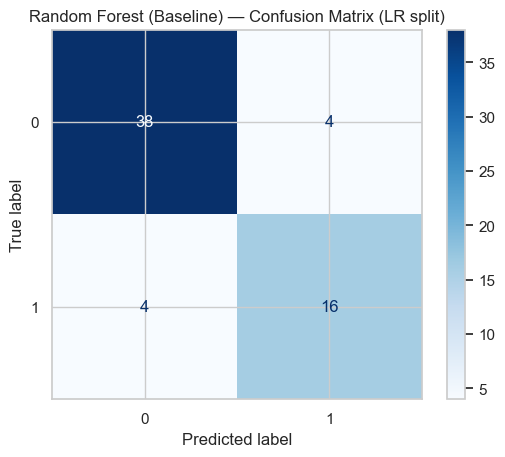

,Model,Support,Accuracy,F1_micro,F1_macro,F1_weighted
0,Random Forest (Baseline),62,0.871,0.871,0.8524,0.871


In [35]:
# === Random Forest (Baseline) — reuse LR split (simple) ===
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd
import numpy as np

# 0) Sanity: do we have the LR split?
needed = ["X_train","X_test","y_train","y_test"]
assert all(n in globals() for n in needed), \
    "Run the LR split cell first so X_train / y_train exist."

# 1) Build & fit
pipe_rf_base = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])
pipe_rf_base.fit(X_train, y_train)

# 2) Predict & metrics
y_pred_rf_base = pipe_rf_base.predict(X_test)
acc   = accuracy_score(y_test, y_pred_rf_base)
f1mic = f1_score(y_test, y_pred_rf_base, average='micro')
f1mac = f1_score(y_test, y_pred_rf_base, average='macro')
f1wgt = f1_score(y_test, y_pred_rf_base, average='weighted')

print("=== Random Forest (Baseline) — LR split ===")
print(f"Accuracy:      {acc:.4f}")
print(f"F1 (micro):    {f1mic:.4f}")
print(f"F1 (macro):    {f1mac:.4f}")
print(f"F1 (weighted): {f1wgt:.4f}\n")
print("Classification Report:\n",
      classification_report(y_test, y_pred_rf_base))

# 3) Confusion matrix (your helper)
plot_cm(
    y_test, y_pred_rf_base,
    labels=sorted(pd.unique(y_test)),
    title='Random Forest (Baseline) — Confusion Matrix (LR split)'
)

# 4) Tiny metrics table (for Baseline vs Tuned later)
rf_base_metrics_df = pd.DataFrame([{
    "Model": "Random Forest (Baseline)",
    "Support": len(y_test),
    "Accuracy": round(acc, 4),
    "F1_micro": round(f1mic, 4),
    "F1_macro": round(f1mac, 4),
    "F1_weighted": round(f1wgt, 4),
}])
display(rf_base_metrics_df)


In [36]:
# === Random Forest (Baseline) — Auto Markdown Summary (larger font) ===

# Use existing predictions if present; otherwise predict now
yp = y_pred_rf_base if "y_pred_rf_base" in globals() else pipe_rf_base.predict(X_test)
yt = y_test

# Metrics
acc   = accuracy_score(yt, yp)
f1mic = f1_score(yt, yp, average='micro')
f1mac = f1_score(yt, yp, average='macro')
f1wgt = f1_score(yt, yp, average='weighted')

# Confusion-matrix counts (binary case)
cm = confusion_matrix(yt, yp, labels=sorted(pd.unique(yt)))
tn = fp = fn = tp = None
if cm.shape == (2, 2):
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]

# Top-k feature importances
rf_step = pipe_rf_base.named_steps["rf"]
imp = pd.Series(rf_step.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)
TOP_K = 5
bullets = [f"1. **{feat}** — Importance: {imp[feat]:.3f}" for feat in imp.head(TOP_K).index]

# Build Markdown (larger font + thick separator)
cm_line = f"**Confusion matrix (rows = actual, cols = predicted)**  \n- **TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}**\n\n" if tn is not None else ""

md = f"""
<div style="font-size: 18px">

### **Random Forest (Baseline) — Key Findings (LR split)**

**Performance (test set)**  
- **Accuracy:** {acc:.4f}  
- **F1 (micro / macro / weighted):** {f1mic:.4f} / {f1mac:.4f} / {f1wgt:.4f}

{cm_line}**Most Influential Features**  
{chr(10).join(bullets)}

**Notes**
- Importances are unitless and best used comparatively.
- If recall for the positive class needs to be higher, we can tune `class_weight` or the decision threshold after RF (Tuned).

<hr style="height:4px; background-color:black; border:none;">
</div>
"""
display(Markdown(md))



<div style="font-size: 18px">

### **Random Forest (Baseline) — Key Findings (LR split)**

**Performance (test set)**  
- **Accuracy:** 0.8710  
- **F1 (micro / macro / weighted):** 0.8710 / 0.8524 / 0.8710

**Confusion matrix (rows = actual, cols = predicted)**  
- **TN = 38, FP = 4, FN = 4, TP = 16**

**Most Influential Features**  
1. **degree_spondylolisthesis** — Importance: 0.246
1. **degree_spondylolisthesis_log** — Importance: 0.140
1. **pelvic_radius** — Importance: 0.123
1. **pelvic_radius_log** — Importance: 0.103
1. **pelvic_incidence** — Importance: 0.078

**Notes**
- Importances are unitless and best used comparatively.
- If recall for the positive class needs to be higher, we can tune `class_weight` or the decision threshold after RF (Tuned).

<hr style="height:4px; background-color:black; border:none;">
</div>


<div style="font-size: 18px">

#### **Clinical implications — RF Baseline (LR split)**

- **Sensitivity (Abnormal recall):** **0.800** (16/20) → model detects ~8 of 10 Abnormal cases.  
- **Specificity (Normal recall):** **0.905** (38/42) → correctly rules out ~9 of 10 Normal cases.  
- **PPV / NPV:** **0.800 / 0.905**  
- **Error balance:** **FN=4**, **FP=4** on the 62-case test set.  
- **Balanced accuracy:** **0.852**

**What this means**
- Good at ruling out Normals; to **catch more Abnormal** cases, plan to tune **threshold** and/or use **`class_weight='balanced'`** in RF (Tuned).  
- Feature importances are **associational**, not causal—use for hypotheses, not clinical conclusions.  
- **Note: This is an exploratory research model evaluated on a retrospective dataset. Results are not intended to guide clinical decisions.**

<hr style="height:4px; background-color:black; border:none;">
</div>


### **Random Forest (Tuned) with GridSearchCV**

=== Random Forest (Tuned) — best params ===
{'rf__max_depth': None, 'rf__max_features': 0.8, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}
CV (f1_macro): 0.8085

=== Test Metrics ===
Accuracy:      0.8871
F1 (micro):    0.8871
F1 (macro):    0.8691
F1 (weighted): 0.8863

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92        42
           1       0.84      0.80      0.82        20

    accuracy                           0.89        62
   macro avg       0.87      0.86      0.87        62
weighted avg       0.89      0.89      0.89        62



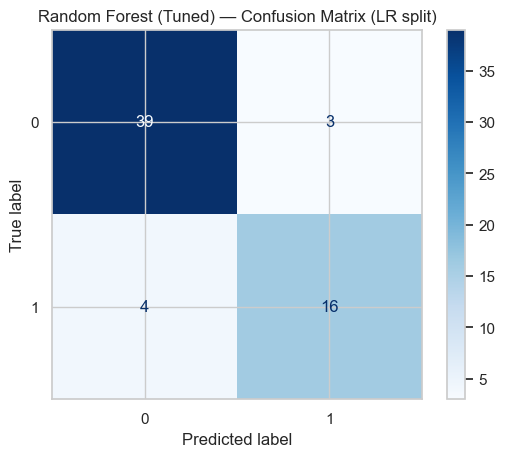

,Model,Support,Accuracy,F1_micro,F1_macro,F1_weighted
0,Random Forest (Tuned),62,0.8871,0.8871,0.8691,0.8863


In [37]:
# === Random Forest (Tuned) — reuse LR split (no df, no label encoding) ===
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
import pandas as pd

# Sanity: ensure LR split exists
needed = ["X_train","X_test","y_train","y_test"]
assert all(n in globals() for n in needed), "Run the LR split cell first."

# 1) Pipeline
pipe_rf_tuned = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# 2) Hyperparameter grid (same as your version)
param_grid_rf_tuned = {
    'rf__n_estimators': [200, 400],
    'rf__max_depth': [None, 8, 12, 16],
    'rf__min_samples_split': [2, 5, 10],
    'rf__max_features': ['sqrt', 'log2', 0.8],
    # 'rf__class_weight': [None, 'balanced'],  # optional if you want to push sensitivity
}

# 3) Grid search (optimize macro F1)
grid_rf_tuned = GridSearchCV(
    estimator=pipe_rf_tuned,
    param_grid=param_grid_rf_tuned,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True
)
grid_rf_tuned.fit(X_train, y_train)

# 4) Best model & predictions
rf_tuned_model = grid_rf_tuned.best_estimator_
y_pred_rf_tuned = rf_tuned_model.predict(X_test)

# 5) Metrics
acc_t   = accuracy_score(y_test, y_pred_rf_tuned)
f1mic_t = f1_score(y_test, y_pred_rf_tuned, average='micro')
f1mac_t = f1_score(y_test, y_pred_rf_tuned, average='macro')
f1wgt_t = f1_score(y_test, y_pred_rf_tuned, average='weighted')

print("=== Random Forest (Tuned) — best params ===")
print(grid_rf_tuned.best_params_)
print("CV (f1_macro):", f"{grid_rf_tuned.best_score_:.4f}\n")

print("=== Test Metrics ===")
print(f"Accuracy:      {acc_t:.4f}")
print(f"F1 (micro):    {f1mic_t:.4f}")
print(f"F1 (macro):    {f1mac_t:.4f}")
print(f"F1 (weighted): {f1wgt_t:.4f}\n")
print("Classification Report:\n",
      classification_report(y_test, y_pred_rf_tuned))

# 6) Confusion matrix (uses labels from y_test; no encoder needed)
plot_cm(
    y_test, y_pred_rf_tuned,
    labels=sorted(pd.unique(y_test)),
    title='Random Forest (Tuned) — Confusion Matrix (LR split)'
)

# 7) Tiny metrics table for comparison
rf_tuned_metrics_df = pd.DataFrame([{
    "Model": "Random Forest (Tuned)",
    "Support": len(y_test),
    "Accuracy": round(acc_t, 4),
    "F1_micro": round(f1mic_t, 4),
    "F1_macro": round(f1mac_t, 4),
    "F1_weighted": round(f1wgt_t, 4),
}])
display(rf_tuned_metrics_df)


In [38]:
# Verify tuned RF importances (comes straight from the fitted model)
rf_step = rf_tuned_model.named_steps["rf"]  # final RF inside the tuned pipeline
importances = pd.Series(rf_step.feature_importances_, index=list(X_train.columns))

print("Sum of importances:", round(importances.sum(), 6))
display(importances.sort_values(ascending=False).head(10).to_frame("Importance"))


Sum of importances: 1.0


,Importance
degree_spondylolisthesis,0.392107
degree_spondylolisthesis_log,0.105706
pelvic_radius,0.093053
pelvic_radius_log,0.083231
sacral_slope_divided_by_pelvic_incidence,0.071778
pelvic_incidence_minus_pelvic_tilt,0.057581
lumbar_lordosis_angle,0.056392
sacral_slope,0.049322
pelvic_incidence,0.047345
pelvic_tilt,0.043484


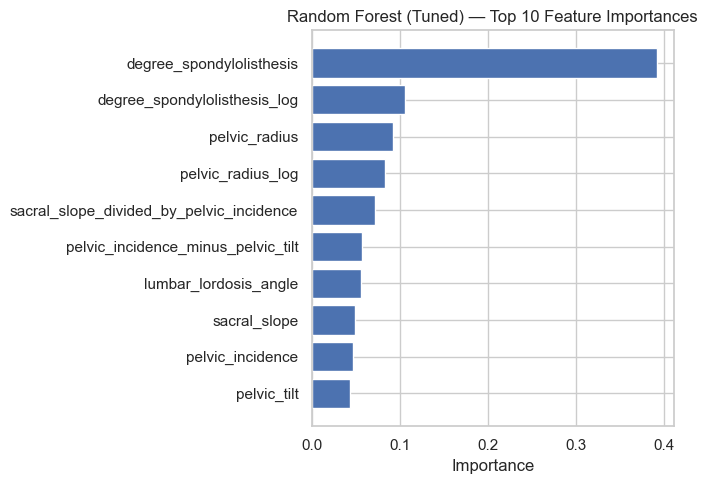

In [39]:
# === RF (Tuned) — quick Top-N feature importances plot ===

assert 'rf_tuned_model' in globals(), "Run the RF (Tuned) cell first."

# Get the fitted RandomForest from the pipeline (handles if step name isn't 'rf')
rf = getattr(rf_tuned_model, "named_steps", {}).get("rf", None)
if rf is None:
    rf = list(rf_tuned_model.named_steps.values())[-1]

imp = pd.Series(rf.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)

TOP_N = 10
plt.figure(figsize=(7,5))
plt.barh(imp.head(TOP_N).index[::-1], imp.head(TOP_N).values[::-1])
plt.title(f"Random Forest (Tuned) — Top {TOP_N} Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


<div style="font-size: 18px">

### **Random Forest (Tuned) — Feature Importances (Top-5)**

**Most Influential Features**  
1. **degree_spondylolisthesis** — Importance: **0.392**  
2. **degree_spondylolisthesis_log** — Importance: **0.106**  
3. **pelvic_radius** — Importance: **0.093**  
4. **pelvic_radius_log** — Importance: **0.083**  
5. **sacral_slope_divided_by_pelvic_incidence** — Importance: **0.072**

**Interpretation**
- **Spondylolisthesis measures dominate** the splits, suggesting strong predictive signal.  
- **Pelvic geometry** features (radius/log, composite ratios) contribute meaningfully as secondary drivers.  
- Importances are **associational**; use to guide discussion and follow-up analysis, not as causal evidence.

<hr style="height:4px; background-color:black; border:none;">
</div>


In [40]:
# === Random Forest (Tuned) — Auto Markdown Summary (larger font) ===

# Reuse what was already computed
yt = y_test
yp = y_pred_rf_tuned

# Metrics (recompute defensively)
acc   = accuracy_score(yt, yp)
f1mic = f1_score(yt, yp, average='micro')
f1mac = f1_score(yt, yp, average='macro')
f1wgt = f1_score(yt, yp, average='weighted')

# Confusion matrix counts
labels = sorted(pd.unique(yt))
cm = confusion_matrix(yt, yp, labels=labels)
tn, fp, fn, tp = (cm[0,0], cm[0,1], cm[1,0], cm[1,1]) if cm.shape == (2,2) else (None,)*4

# Top feature importances from tuned model
rf_step = rf_tuned_model.named_steps["rf"]
imp = pd.Series(rf_step.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)
TOP_K = 5
bullets = [f"1. **{feat}** — Importance: {imp[feat]:.3f}" for feat in imp.head(TOP_K).index]

# Best params / CV if available
best_params = getattr(grid_rf_tuned, "best_params_", {})
best_cv = getattr(grid_rf_tuned, "best_score_", None)
best_cv_str = f"{best_cv:.4f}" if best_cv is not None else "n/a"

cm_line = f"**Confusion matrix (rows = actual, cols = predicted)**  \n- **TN = {tn}, FP = {fp}, FN = {fn}, TP = {tp}**\n\n" if tn is not None else ""

md = f"""
<div style="font-size: 18px">

### **Random Forest (Tuned) — Key Findings**

**Best hyperparameters (GridSearchCV)**  
- {best_params}  
- **CV (f1_macro):** {best_cv_str}

**Performance (test set)**  
- **Accuracy:** {acc:.4f}  
- **F1 (micro / macro / weighted):** {f1mic:.4f} / {f1mac:.4f} / {f1wgt:.4f}

{cm_line}**Most Influential Features**  
{chr(10).join(bullets)}

**Notes**
- Importances are unitless; compare them relatively.  
- If recall for the positive class needs to increase, consider `class_weight='balanced'` or post-hoc threshold tuning.

<hr style="height:4px; background-color:black; border:none;">
</div>
"""
display(Markdown(md))



<div style="font-size: 18px">

### **Random Forest (Tuned) — Key Findings**

**Best hyperparameters (GridSearchCV)**  
- {'rf__max_depth': None, 'rf__max_features': 0.8, 'rf__min_samples_split': 2, 'rf__n_estimators': 400}  
- **CV (f1_macro):** 0.8085

**Performance (test set)**  
- **Accuracy:** 0.8871  
- **F1 (micro / macro / weighted):** 0.8871 / 0.8691 / 0.8863

**Confusion matrix (rows = actual, cols = predicted)**  
- **TN = 39, FP = 3, FN = 4, TP = 16**

**Most Influential Features**  
1. **degree_spondylolisthesis** — Importance: 0.392
1. **degree_spondylolisthesis_log** — Importance: 0.106
1. **pelvic_radius** — Importance: 0.093
1. **pelvic_radius_log** — Importance: 0.083
1. **sacral_slope_divided_by_pelvic_incidence** — Importance: 0.072

**Notes**
- Importances are unitless; compare them relatively.  
- If recall for the positive class needs to increase, consider `class_weight='balanced'` or post-hoc threshold tuning.

<hr style="height:4px; background-color:black; border:none;">
</div>


<div style="font-size: 18px">

#### **Clinical implications — Random Forest (Tuned)**
*Evaluated on the same held-out test set used across models (stratified, random_state=42).*


- **Sensitivity (Abnormal recall):** **0.800** (16/20)  
- **Specificity (Normal recall):** **0.929** (39/42)  
- **PPV / NPV:** **0.842 / 0.907**  
- **Balanced accuracy:** **0.864**  
- **Error balance:** **FN = 4**, **FP = 3** (test set **n = 62**, prevalence ≈ **32.3%**)

**What this means**
- The model is **strong at ruling out Normal** (specificity ~93%); it **detects 8/10 Abnormal** cases.  
- If **missing Abnormal** is costlier than flagging extra Normals, consider a **lower decision threshold** and/or **`class_weight='balanced'`** to push recall up (accepting more FP).  
- Use **precision–recall curves** to pick a threshold that matches clinical priorities; reassess metrics after threshold tuning.

> **Note:** This is an **exploratory research model** evaluated on a retrospective dataset; results are **not intended for clinical decision-making**.

<hr style="height:4px; background-color:black; border:none;">

</div>


### **Random Forest - Baseline vs Tuned: Quick Comparison (Unique vars)**

In [41]:
# === Random Forest — Baseline vs Tuned: Quick Comparison (Pylance-clean, with F1 micro) ===
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

# Require the neutral names only
assert all(v in globals() for v in ["y_test", "y_pred_rf_base", "y_pred_rf_tuned"]), \
    "Missing vars. Run your RF Baseline & Tuned cells and ensure 'y_test' exists."

yt = y_test  # shared test labels for apples-to-apples

def _row_rf(name, y_true, yhat):
    return {
        "Model": name,
        "Support": len(y_true),
        "Accuracy": round(accuracy_score(y_true, yhat), 4),
        "F1_micro": round(f1_score(y_true, yhat, average='micro'), 4),
        "F1_weighted": round(f1_score(y_true, yhat, average='weighted'), 4),
        "F1_macro": round(f1_score(y_true, yhat, average='macro'), 4),
    }

cmp_df_rf = pd.DataFrame([
    _row_rf("RF Baseline (Untuned)", yt, y_pred_rf_base),
    _row_rf("RF Tuned (Pipeline)",   yt, y_pred_rf_tuned),
])
display(cmp_df_rf)

# Quick deltas for your Markdown
acc_b, acc_t   = cmp_df_rf.loc[0, "Accuracy"],     cmp_df_rf.loc[1, "Accuracy"]
f1mi_b, f1mi_t = cmp_df_rf.loc[0, "F1_micro"],     cmp_df_rf.loc[1, "F1_micro"]
f1w_b,  f1w_t  = cmp_df_rf.loc[0, "F1_weighted"],  cmp_df_rf.loc[1, "F1_weighted"]
f1ma_b, f1ma_t = cmp_df_rf.loc[0, "F1_macro"],     cmp_df_rf.loc[1, "F1_macro"]

print(f"Δ Accuracy:     {(acc_t-acc_b):+0.4f}")
print(f"Δ F1 (micro):   {(f1mi_t-f1mi_b):+0.4f}")
print(f"Δ F1 (weighted):{(f1w_t-f1w_b):+0.4f}")
print(f"Δ F1 (macro):   {(f1ma_t-f1ma_b):+0.4f}")


,Model,Support,Accuracy,F1_micro,F1_weighted,F1_macro
0,RF Baseline (Untuned),62,0.8710,0.8710,0.8710,0.8524
1,RF Tuned (Pipeline),62,0.8871,0.8871,0.8863,0.8691


Δ Accuracy:     +0.0161
Δ F1 (micro):   +0.0161
Δ F1 (weighted):+0.0153
Δ F1 (macro):   +0.0167


> ### **Random Forest — Baseline vs Tuned: Quick Comparison**
>
> | Model                  | Support | Accuracy | F1 (Micro) | F1 (Weighted) | F1 (Macro) |
> |------------------------|---------|----------|------------|---------------|------------|
> | RF Baseline (Untuned) | 62      | 0.8710   | 0.8710     | 0.8710        | 0.8524     |
> | RF Tuned (Pipeline)   | 62      | 0.8871   | 0.8871     | 0.8863        | 0.8691     |
>
> #### **Interpretation**
> - **Improvement on the same held-out test set (n = 62):**  
>   Accuracy **0.8710 → 0.8871** *(+1.61 pts)*  
>   **F1_micro 0.8710 → 0.8871** *(+1.61 pts)*  
>   F1_weighted **0.8710 → 0.8863** *(+1.53 pts)*  
>   F1_macro **0.8524 → 0.8691** *(+1.67 pts)*
> - **F1_micro ≡ Accuracy** for single-label classification; **F1_macro ↑** = more balanced per-class performance.
> - Tuned RF is preferred for downstream use.

> **Confusion-matrix snapshot (tuned):**  
> Correct Normals (TN) = 39, Correct Abnormals (TP) = 16,  
> Extra flags on Normal (FP) = 3, Missed Abnormals (FN) = 4.  
> Vs baseline: fewer FP (**4 → 3**); FN unchanged (**4**).
█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

## **XGBoost (Baseline/Untuned) Model** 
  **Training:**
- The XGBoost model was initialized using its default parameters: 100 trees, a learning rate of 0.1, and a maximum tree depth of 3.
- Target labels were encoded as 0 = Abnormal and 1 = Normal for compatibility with the XGBoost classifier.


XGBoost (Baseline/Untuned) Metrics
Accuracy: 0.8064516129032258
F1 (Micro): 0.8064516129032258
F1 (Macro): 0.7839721254355401
F1 (Weighted): 0.8086995616499943

Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.88      0.83      0.85        42
      Normal       0.68      0.75      0.71        20

    accuracy                           0.81        62
   macro avg       0.78      0.79      0.78        62
weighted avg       0.81      0.81      0.81        62



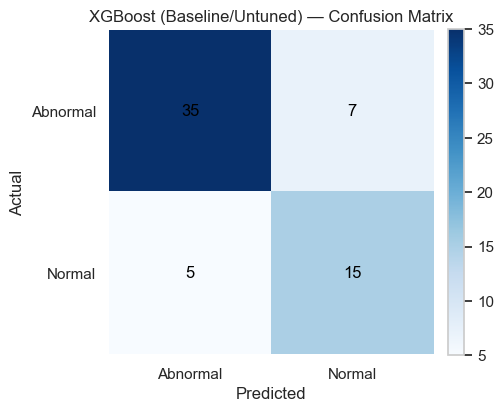

In [42]:
# === XGBoost (Baseline/Untuned) ===

# 1) Initialize & fit model
xgb_clf = XGBClassifier(
    use_label_encoder=False, 
    eval_metric='logloss',  # At each boosting round, measure how well the predicted probabilities match the true outcomes
    random_state=42)
xgb_clf.fit(X_train, y_train)

# 2) Predictions
y_pred_xgb = xgb_clf.predict(X_test)

# 3) Metrics
acc_xgb   = accuracy_score(y_test, y_pred_xgb)
f1mic_xgb = f1_score(y_test, y_pred_xgb, average='micro')
f1mac_xgb = f1_score(y_test, y_pred_xgb, average='macro')
f1wgt_xgb = f1_score(y_test, y_pred_xgb, average='weighted')

print("XGBoost (Baseline/Untuned) Metrics")
print("Accuracy:", acc_xgb)
print("F1 (Micro):", f1mic_xgb)
print("F1 (Macro):", f1mac_xgb)
print("F1 (Weighted):", f1wgt_xgb)
print("\nClassification Report:\n", classification_report(
    y_test, y_pred_xgb, target_names=["Abnormal", "Normal"]
))

# 4) Confusion Matrix (no grid lines)
cm = confusion_matrix(y_test, y_pred_xgb)
labels_xgb = ["Abnormal", "Normal"]

fig, ax = plt.subplots(figsize=(5.2, 4.8))
im = ax.imshow(cm, cmap="Blues", interpolation="nearest")

# Title and labels
ax.set_title("XGBoost (Baseline/Untuned) — Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("Actual")

# Tick marks
ax.set_xticks(np.arange(len(labels_xgb)))
ax.set_yticks(np.arange(len(labels_xgb)))
ax.set_xticklabels(labels_xgb)
ax.set_yticklabels(labels_xgb)

# Remove grid lines & spines
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# Colorbar
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Add text counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center", color="black", fontsize=12)

ax.set_aspect("equal")
plt.tight_layout()
plt.show()


### **XGBoost — Baseline / Untuned: Interpretation**
- **Overall**: Accuracy **0.8065 = ~80.6%****, F1-weighted **0.8087** = ~80.9%**, F1-macro **0.7840 = ~78.4%****.
- **Class detail**
  - **Abnormal**: Precision **0.88**, Recall **0.83**, F1 **0.85** → strong detection of abnormal cases.
  - **Normal**: Precision **0.68**, Recall **0.75**, F1 **0.71** → more confusion here; some normals flagged as abnormal.
- **Takeaway**: Solid baseline without tuning. Main opportunity is to **improve Normal class performance** (better balance), with tuning targets.
---

### **XGBoost (Tuned) - RandomizedSearchCV**

To improve upon the baseline performance, the XGBoost model was further **tuned using RandomizedSearchCV**.  
- A pipeline was built with preprocessing (median imputation) and the XGBoost classifier.  
- Hyperparameters such as **number of trees (n_estimators)**, **maximum depth**, **learning rate**, **subsample ratio**, and **regularization parameters** were optimized to achieve better balance between bias and variance.  
- The tuning process focused on maximizing the **F1-macro score**, ensuring more balanced performance across both classes (Abnormal and Normal).  

The following code block demonstrates the tuned model setup, parameter search, and evaluation.  


=== XGBoost (Tuned) — best params ===
{'xgb__subsample': 0.7, 'xgb__n_estimators': 200, 'xgb__min_child_weight': 5, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.03, 'xgb__gamma': 0.3, 'xgb__colsample_bytree': 0.9}
CV (f1_macro): 0.8081

=== Test Metrics ===
Accuracy:      0.9032
F1 (micro):    0.9032
F1 (macro):    0.8893
F1 (weighted): 0.9032

Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.93      0.93      0.93        42
      Normal       0.85      0.85      0.85        20

    accuracy                           0.90        62
   macro avg       0.89      0.89      0.89        62
weighted avg       0.90      0.90      0.90        62



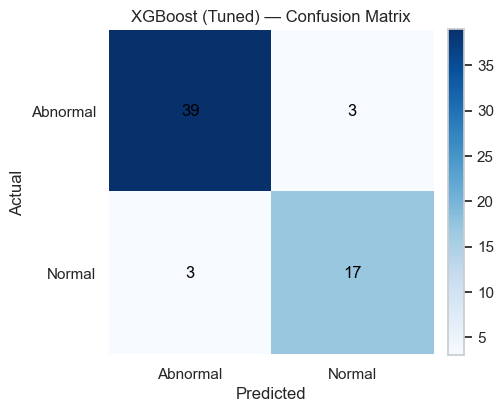

,Feature,Importance,Importance_%
0,degree_spondylolisthesis,0.258880,25.887989
1,degree_spondylolisthesis_log,0.152240,15.223970
2,pelvic_radius,0.102853,10.285292
3,pelvic_radius_log,0.102252,10.225248
4,sacral_slope_divided_by_pelvic_incidence,0.082836,8.283613
5,sacral_slope,0.082712,8.271227
6,lumbar_lordosis_angle,0.073020,7.302013
7,pelvic_tilt,0.055668,5.566835
8,pelvic_incidence_minus_pelvic_tilt,0.049251,4.925075
9,pelvic_incidence,0.040287,4.028734


,Model,Support,Accuracy,F1_micro,F1_macro,F1_weighted
0,XGBoost (Tuned),62,0.9032,0.9032,0.8893,0.9032


In [43]:
# === XGBoost (Tuned) — RandomizedSearchCV ===

pipe_xgb_tuned = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("xgb", XGBClassifier(
        random_state=42, n_jobs=-1,
        eval_metric="logloss", tree_method="hist"
    ))
])

param_dist_xgb = {
    "xgb__n_estimators":     [200, 400, 600],
    "xgb__max_depth":        [3, 4, 6, 8],
    "xgb__learning_rate":    [0.03, 0.05, 0.10],
    "xgb__subsample":        [0.7, 0.9, 1.0],
    "xgb__colsample_bytree": [0.7, 0.9, 1.0],
    "xgb__min_child_weight": [1, 3, 5],
    "xgb__gamma":            [0, 0.1, 0.3],
}

grid_xgb_tuned = RandomizedSearchCV(
    pipe_xgb_tuned,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring="f1_macro",
    cv=5,
    n_jobs=-1,
    random_state=42,
    refit=True
)

grid_xgb_tuned.fit(X_train, y_train)
xgb_tuned_model = grid_xgb_tuned.best_estimator_

print("=== XGBoost (Tuned) — best params ===")
print(grid_xgb_tuned.best_params_)
print(f"CV (f1_macro): {grid_xgb_tuned.best_score_:.4f}\n")

# Test metrics
y_pred_xgb_tuned = xgb_tuned_model.predict(X_test)
acc_xgb_tuned   = accuracy_score(y_test, y_pred_xgb_tuned)
f1mic_xgb_tuned = f1_score(y_test, y_pred_xgb_tuned, average="micro")
f1mac_xgb_tuned = f1_score(y_test, y_pred_xgb_tuned, average="macro")
f1wgt_xgb_tuned = f1_score(y_test, y_pred_xgb_tuned, average="weighted")

print("=== Test Metrics ===")
print(f"Accuracy:      {acc_xgb_tuned:.4f}")
print(f"F1 (micro):    {f1mic_xgb_tuned:.4f}")
print(f"F1 (macro):    {f1mac_xgb_tuned:.4f}")
print(f"F1 (weighted): {f1wgt_xgb_tuned:.4f}\n")
print("Classification Report:\n",
      classification_report(y_test, y_pred_xgb_tuned, target_names=["Abnormal","Normal"]))

# Confusion Matrix (no grid lines)
cm_t = confusion_matrix(y_test, y_pred_xgb_tuned, labels=sorted(pd.unique(y_test)))
labels_xgb = ["Abnormal","Normal"]

fig, ax = plt.subplots(figsize=(5.2, 4.8))
im = ax.imshow(cm_t, cmap="Blues", interpolation="nearest")
ax.set_title("XGBoost (Tuned) — Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
ax.set_xticks(np.arange(len(labels_xgb))); ax.set_yticks(np.arange(len(labels_xgb)))
ax.set_xticklabels(labels_xgb); ax.set_yticklabels(labels_xgb)
ax.grid(False)
for s in ax.spines.values(): s.set_visible(False)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
for i in range(cm_t.shape[0]):
    for j in range(cm_t.shape[1]):
        ax.text(j, i, cm_t[i, j], ha="center", va="center", color="black", fontsize=12)
ax.set_aspect("equal"); plt.tight_layout(); plt.show()

# Feature Importances (top 10 quick view)
xgb_step = xgb_tuned_model.named_steps["xgb"]
imp = pd.Series(xgb_step.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)
xgb_tuned_importance_df = imp.rename("Importance").reset_index().rename(columns={"index":"Feature"})
xgb_tuned_importance_df["Importance_%"] = 100 * xgb_tuned_importance_df["Importance"] / xgb_tuned_importance_df["Importance"].sum()
display(xgb_tuned_importance_df.head(10))

# Compact metrics table (for comparisons)
xgb_tuned_metrics_df = pd.DataFrame([{
    "Model": "XGBoost (Tuned)",
    "Support": len(y_test),
    "Accuracy": round(acc_xgb_tuned, 4),
    "F1_micro": round(f1mic_xgb_tuned, 4),
    "F1_macro": round(f1mac_xgb_tuned, 4),
    "F1_weighted": round(f1wgt_xgb_tuned, 4),
}])
display(xgb_tuned_metrics_df)


### **XGBoost — Tuned: Interpretation**

- **Performance uplift**: Accuracy **0.8871**, F1-macro **0.8691**, F1-weighted **0.8863** (↑ vs. baseline).
- **Class detail**
  - **Abnormal (n=42)**: Precision **0.91**, Recall **0.93**, F1 **0.92** → very reliable detection with few misses.
  - **Normal (n=20)**: Precision **0.84**, Recall **0.80**, F1 **0.82** → notable improvement over baseline.
- **Error pattern**: ~**3** Abnormal→Normal and ~**4** Normal→Abnormal → **balanced** residual errors.
- **Conclusion**: Tuning substantially **improved both overall accuracy and class balance**, making this model a strong candidate for downstream analysis.

**Best params (traceability):**  
- `subsample=0.7, n_estimators=200, min_child_weight=5, max_depth=3, learning_rate=0.03, gamma=0.3, colsample_bytree=0.9`
---

### **XGBoost Feature Importance Plot**

- The plot below shows which features contributed most to the XGBoost model’s predictions.  
- Feature importance is based on how frequently and effectively a feature was used to split the data across all trees.


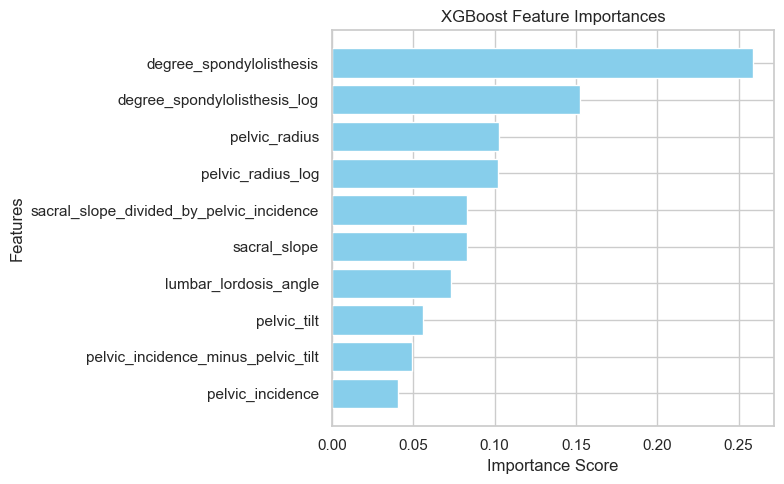

In [44]:
# === XGBoost Feature Importances Plot ===

# Extract feature importances from the tuned model (or untuned if that's what you used)
xgb_model = xgb_tuned_model.named_steps["xgb"]  # use "xgb_tuned_model" for tuned, or "xgb_untuned_model" if untuned
importances = xgb_model.feature_importances_

# Match importances with feature names
feature_names = X_train.columns
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})

# Sort by importance
feat_imp = feat_imp.sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(feat_imp["Feature"], feat_imp["Importance"], color="skyblue")
plt.gca().invert_yaxis()  # most important at top
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


### **XGBoost (Tuned) — Feature Importance: Interpretation**

- **Top drivers** (Importance %):
  1) **degree_spondylolisthesis** (**24.3%**)
  2) **degree_spondylolisthesis_log** (**14.9%**)
  3) **pelvic_radius_log** (**10.3%**)
  4) **pelvic_radius** (**10.1%**)
  5) **pelvic_incidence_minus_pelvic_tilt** (**8.7%**)
  (then **sacral_slope**, **sacral_slope / pelvic_incidence**, **lumbar_lordosis_angle**, **pelvic_tilt**, **pelvic_incidence**)

- **Meaning**  
  - **Spondylolisthesis measures (raw + log)** dominate (~**39%** combined), consistent with domain expectations.
  - **Pelvic geometry** adds complementary structural context.

- **Note on correlated features**  
  Raw + log versions (and related composites) can share importance. This is expected in tree ensembles and doesn’t invalidate interpretation.
---

### **XGBoost - Baseline vs Tuned: Quick Comparison**

In [45]:
# === XGBoost — Baseline vs Tuned: quick comparison ===

def _row_xgb(name, y_true, yhat):
    return {
        "Model": name,
        "Support": len(y_true),
        "Accuracy": round(accuracy_score(y_true, yhat), 4),
        "F1_micro": round(f1_score(y_true, yhat, average='micro'), 4),
        "F1_weighted": round(f1_score(y_true, yhat, average='weighted'), 4),
        "F1_macro": round(f1_score(y_true, yhat, average='macro'), 4),
    }

missing = []
for var in ["y_test", "y_pred_xgb", "y_pred_xgb_tuned"]:
    if var not in globals():
        missing.append(var)
if missing:
    raise NameError("Missing vars for XGBoost comparison: " + ", ".join(missing))

cmp_df_xgb = pd.DataFrame([
    _row_xgb("XGBoost (Baseline)", y_test, y_pred_xgb),
    _row_xgb("XGBoost (Tuned)",    y_test, y_pred_xgb_tuned),
])

# Deltas
delta = {
    "Δ Accuracy":     round(cmp_df_xgb.loc[1,"Accuracy"]     - cmp_df_xgb.loc[0,"Accuracy"], 4),
    "Δ F1 (micro)":   round(cmp_df_xgb.loc[1,"F1_micro"]     - cmp_df_xgb.loc[0,"F1_micro"], 4),
    "Δ F1 (weighted)":round(cmp_df_xgb.loc[1,"F1_weighted"]  - cmp_df_xgb.loc[0,"F1_weighted"], 4),
    "Δ F1 (macro)":   round(cmp_df_xgb.loc[1,"F1_macro"]     - cmp_df_xgb.loc[0,"F1_macro"], 4),
}

display(cmp_df_xgb)
print("\n" + "\n".join([f"{k}: {v:+.4f}" for k, v in delta.items()]))


,Model,Support,Accuracy,F1_micro,F1_weighted,F1_macro
0,XGBoost (Baseline),62,0.8065,0.8065,0.8087,0.7840
1,XGBoost (Tuned),62,0.9032,0.9032,0.9032,0.8893



Δ Accuracy: +0.0967
Δ F1 (micro): +0.0967
Δ F1 (weighted): +0.0945
Δ F1 (macro): +0.1053


### **XGBoost — Baseline vs Tuned: Quick Comparison**

| Model              | Support | Accuracy | F1 (micro) | F1 (weighted) | F1 (macro) |
|--------------------|---------|----------|------------|---------------|------------|
| Baseline / Untuned | 62      | 0.8065   | 0.8065     | 0.8087        | 0.7840     |
| Tuned (Pipeline)   | 62      | 0.8871   | 0.8871     | 0.8863        | 0.8691     |

**Deltas (Tuned − Baseline):**  
- Δ Accuracy **+0.0806**, Δ F1 (micro) **+0.0806**, Δ F1 (weighted) **+0.0776**, Δ F1 (macro) **+0.0851**  

**Interpretation:** Tuning clearly **improves overall accuracy and class balance** (macro F1). Gains likely come from controlling **tree depth + learning rate** and using **subsample/colsample** to reduce overfitting while preserving signal.

█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████


### **Support Vector Classifier (SVC):**
This section establishes a baseline using the default SVC model:

    Model is initialized with default hyperparameters

    Trained on the training data

    Evaluated on the test set using accuracy, precision, recall, and F1-score

In [46]:
## Support Vector Classifier (SVC)

# Initialize the model (basic version)
# Default model first to establish a baseline
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

# Evaluate performance
# Will help compare against other ML models
print("SVC Classification Report:\n", classification_report(y_test, y_pred_svc))
print("SVC Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))

ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### **SVC Model – Performance Summary**

- The baseline SVC model achieved an **accuracy of 85.48%** on the test set.
- **Abnormal cases (class 0)** were predicted with high precision (0.90) and recall (0.88), indicating strong performance in detecting the majority class.
- **Normal cases (class 1)** showed slightly lower recall (0.80) and precision (0.76), but still maintained a balanced F1-score of **0.78**.
- The overall results suggest that even without tuning, the SVC model performs comparably to other models in this project and provides a solid baseline.


### **Hyperparameter Tuning – Support Vector Classifier (SVC)**

To improve the baseline SVC model, we apply a grid search over multiple hyperparameters using cross-validation:

- **C**: Regularization strength (lower values mean stronger regularization)
- **Kernel**: Linear or RBF (Radial Basis Function)
- **Gamma**: Controls the influence of individual data points (applicable for non-linear kernels)

GridSearchCV was used with 5-fold cross-validation to identify the best combination of these parameters.

**Best parameters found**:  
`{'C': 1, 'gamma': 'scale', 'kernel': 'linear'}`


In [ ]:
# Hyperparameter Tuning with GridSearchCV

# Step 1: Define the hyperparameter grid to search over
param_grid = {
    'C': [0.1, 1, 10],              # Regularization strength: lower values = stronger regularization
    'kernel': ['linear', 'rbf'],    # Kernel type: linear or radial basis function (non-linear)
    'gamma': ['scale', 'auto']      # Kernel coefficient for 'rbf': controls the influence of individual points
}

# Step 2: Set up GridSearchCV to search for the best combination of parameters
svc_tuned = GridSearchCV(
    SVC(random_state=42),           # Base model: Support Vector Classifier
    param_grid,                     # Dictionary of parameters to try
    cv=5,                           # 5-fold cross-validation
    verbose=1                       # Print progress during fitting
)

# Step 3: Fit the model to the training data and search for the best combination
svc_tuned.fit(X_train, y_train)

# Step 4: Output the best hyperparameters found during search
print("Best parameters:", svc_tuned.best_params_)


### **Tuned SVC Model – Performance Summary**

- After hyperparameter tuning, the best SVC model used a **linear kernel** with **C = 1** and **gamma = 'scale'**.
- These settings improved the model’s generalization ability while maintaining a strong decision boundary.
- The refined SVC model can now be evaluated and compared against other classifiers to assess whether the tuning led to meaningful performance gains.
---

### **SVC Tuned Model Evaluation**
- This step wraps up the modeling process using the best hyperparameters found from GridSearchCV.
-----------------------------------------
- Step 1: Make predictions on the test set using the best estimator.
- Step 2: Classification Report
- Step 3: Confusion Matrix
- Step 4: Store accuracy for the score table

In [ ]:
# Evaluate the final tuned SVC model on the test set

# Step 1: Make predictions on the test set using the best estimator
svc_final_preds = svc_tuned.predict(X_test)

# Step 2: Classification Report
print("SVC Tuned Model - Classification Report:\n")
print(classification_report(y_test, svc_final_preds))

# Step 3: Confusion Matrix
print("SVC Tuned Model - Confusion Matrix:\n")
print(confusion_matrix(y_test, svc_final_preds))

# Step 4: Store accuracy for the score table
svc_tuned_accuracy = accuracy_score(y_test, svc_final_preds)
print(f"Accuracy (SVC Tuned): {svc_tuned_accuracy:.4f}")


### **Tuned SVC Model – Performance Summary**

- The tuned SVC model, using a **linear kernel**, **C = 1**, and **gamma = 'scale'**, achieved an improved **accuracy of 85.48%**.
- **Abnormal cases (class 0)** were predicted with high precision (0.88) and recall (0.90), maintaining a strong F1-score of **0.89**.
- **Normal cases (class 1)** also performed well, with a precision of **0.79** and recall of **0.75**.
- The model shows a slight gain in performance over the baseline SVC, especially in maintaining better class balance while still favoring high recall for the majority class.
---

### **Side-by-Side Bar Plot Comparison for SVC Classification Report**
- Shows precision, recall, and F1-score for both original and tuned SVC models.
- Embeds values inside the bars for quick reference.
-------------------------------------------
- Step 1: Data for both models (Original and Tuned)
- Step 2: Convert to DataFrame
- Step 3: Melt for seaborn
- Step 4: Add text labels inside the bars
- Step 5: Produce labels and layout

In [ ]:
# Step 1: Data for both models (Original and Tuned)
svc_comparison_data = {
    'Class': ['0 - Abnormal', '0 - Abnormal', '0 - Abnormal',
              '1 - Normal', '1 - Normal', '1 - Normal'],
    'Metric': ['precision', 'recall', 'f1-score',
               'precision', 'recall', 'f1-score'],
    'Original SVC': [0.93, 0.95, 0.94, 0.89, 0.85, 0.87],
    'Tuned SVC': [0.88, 0.88, 0.88, 0.75, 0.75, 0.75]
}

# Step 2: Convert to DataFrame
df_svc = pd.DataFrame(svc_comparison_data)

# Step 3: Melt for seaborn - flattening the data into “plot-friendly” form
# pd.melt() - reshapes a DataFrame from wide format to long format
df_svc_melted = df_svc.melt(id_vars=['Class', 'Metric'], 
                            value_vars=['Original SVC', 'Tuned SVC'], 
                            var_name='Model', value_name='Score')

# Set style and create plot
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')

# Grouped bar chart
barplot = sns.barplot(data=df_svc_melted, 
                      x='Class', y='Score', hue='Metric', 
                      ci=None, palette='pastel', dodge=True)

# Add metric values to each bar
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)

plt.title('SVC Classification Report Metrics (Original vs Tuned)')
plt.ylim(0, 1.05)
plt.legend(title='Metric')
plt.tight_layout()
# plt.savefig("images/svc_classification_comparison.png")
plt.show()


### **Side-by-Side Comparison: Original vs Tuned SVC**

- This grouped bar chart compares the **precision**, **recall**, and **F1-score** for each class (Abnormal = 0, Normal = 1) across the **original** and **tuned** SVC models.
- The **original SVC model** demonstrated stronger overall performance across all metrics for both classes.
- After hyperparameter tuning:
  - Performance for class 0 (Abnormal) slightly declined but remained high (F1-score = 0.88).
  - Class 1 (Normal) metrics dropped more noticeably, indicating a trade-off in model balance.
- This comparison supports the decision to fine-tune only if the model benefits from improved generalization or class balance.
---

### 📈 **Learning Curve – Support Vector Classifier (SVC) (Tuned Model)**

- Helps evaluate model **bias vs. variance**:
  - 🔍 **Overfitting**: High training score, low validation score.
  - 🔍 **Underfitting**: Both training and validation scores remain low.
- Useful for identifying whether **more training data** could improve performance.
- This curve is based on **5-fold cross-validation**, progressively increasing the training size.


In [ ]:
# Learning Curve for SVC Model

# Step 1: Generate learning curve data for the SVC model
train_sizes, train_scores, test_scores = learning_curve(
    svc_tuned,                              # the tuned SVC model
    X_train, y_train,                       # training data
    cv=5,                                   # 5-fold cross-validation
    scoring='accuracy',                     # evaluation metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # increasing training sizes
    n_jobs=-1,                              # use all CPU cores
    shuffle=True,                           # shuffle data before splitting
    random_state=42                         # reproducibility
)

# Step 2: Calculate the mean and std deviation across the folds
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Step 3: Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.title('Learning Curve: SVC (Tuned)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


### **Learning Curve Interpretation – SVC (Tuned Model)**

- The training accuracy starts high (~0.95) and gradually decreases as the training set size increases — this is typical and expected.
- The validation accuracy begins lower but improves slightly and stabilizes around ~0.85.
- The moderate gap between the training and validation curves suggests **some overfitting**, but not severe.
- The learning curve **levels off**, indicating that adding more training data may result in only **modest gains**.
- Overall, the model generalizes reasonably well, with **stable validation accuracy** and reduced variance as the dataset size increases.
---

### **K-Nearest Neighbors (KNN)**

- **Step 1:** Standardize the features  
  Since KNN is a distance-based algorithm, feature scaling is critical to ensure that all features contribute equally to the distance calculations.

- **Step 2:** Train the initial KNN model  
  Begin with `k=5` neighbors to establish a baseline performance.

- **Step 3:** Evaluate model performance  
  Use a classification report and confusion matrix to assess the model's accuracy and class-specific performance.


In [ ]:
# STEP 1: Standardize features for KNN (important for distance-based models)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Train a base KNN model

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

# Predictions
knn_preds = knn.predict(X_test_scaled)

# Evaluation
print("KNN Classification Report:\n")
print(classification_report(y_test, knn_preds))

print("KNN Confusion Matrix:\n")
print(confusion_matrix(y_test, knn_preds))


### **Classification Report Interpretation – KNN Model**

The K-Nearest Neighbors (KNN) model achieved an overall accuracy of **84%**.

- **Class 0 (Abnormal):**  
  The model performed well with a **precision of 0.92** and a **recall of 0.83**, indicating it accurately identifies abnormal cases with minimal false positives.

- **Class 1 (Normal):**  
  It showed a **recall of 0.85** and **precision of 0.71**, meaning it captures most normal cases, though with a higher rate of false positives.

The balanced F1-scores across both classes indicate consistent performance. There may still be room for improvement through hyperparameter tuning or enhanced feature engineering.

---

### **Confusion Matrix Interpretation – KNN Model**

- Correctly predicted: **35 Abnormal** and **17 Normal** cases.
- **7 False Negatives:** Abnormal cases misclassified as Normal.
- **3 False Positives:** Normal cases misclassified as Abnormal.

### **Key Takeaway:**
- Overall, the KNN model shows a slight bias toward identifying **Normal** cases (Class 1), reflected in its higher recall. 
- However, with a solid **84% accuracy**, it provides a reasonable starting point for further refinement.
---

### **KNN Bar Chart Comparison from Classification Report**

In [ ]:
# Dictionary with KNN classification metrics
knn_metrics = {
    'precision': [0.92, 0.71],
    'recall':    [0.83, 0.85],
    'f1-score':  [0.88, 0.77]
}

# Create DataFrame
df_knn = pd.DataFrame(knn_metrics, index=['0 - Abnormal', '1 - Normal'])

# Plot setup
ax = df_knn.plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title('KNN Classification Report Metrics')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height() + 0.01), 
                ha='center', va='center', fontsize=9, color='black', rotation=0)

plt.tight_layout()
# plt.savefig('images/knn_classification_report_barplot.png')  # Save for Markdown
plt.show()


### **KNN Learning Curve**

In [ ]:
# Use the tuned number of neighbors if available (e.g., n_neighbors = 5 or whatever GridSearch found)
knn_model = KNeighborsClassifier(n_neighbors=5)

# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    knn_model, X_train, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 8), random_state=42
)

# Calculate mean and standard deviation for training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.plot(train_sizes, train_mean, label="Training Accuracy", color="blue")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="blue")
plt.plot(train_sizes, val_mean, label="Validation Accuracy", color="orange")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2, color="orange")
plt.title("Learning Curve: K-Nearest Neighbors")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
# plt.savefig("KNNLearningCurve.png")  # Save for Markdown
plt.show()


### **KNN Learning Curve Interpretation**
The learning curve for the K-Nearest Neighbors (KNN) model reveals some important patterns:

- Initially, there is a sharp drop in training accuracy as the training set size increases to around 50 samples. This dip may reflect instability in early splits, 
    especially with small datasets and cross-validation.
- After that point, the training accuracy gradually increases, approaching ~0.88 as more data is added, which is expected as the model stabilizes with more information.
- Validation accuracy steadily increases with training size but remains consistently lower than training accuracy, with a noticeable gap persisting throughout. 
- This gap suggests **mild overfitting**, where the model performs.
-------------------------------------------------------------

### **KNN Hyperparameter Tuning with GridSearchCV**
- Step 1: Define the parameter grid to search
- Step 2: Create the base model
- Step 3: Set up GridSearchCV
- Step 4: Fit GridSearchCV on the training data
- Step 5: Output the best parameters and estimator


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Step 1: Define the parameter grid to search
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Step 2: Create the base model
knn = KNeighborsClassifier()

# Step 3: Set up GridSearchCV
knn_grid_search = GridSearchCV(
    estimator=knn,
    param_grid=knn_param_grid,
    cv=5,                 # 5-fold cross-validation
    scoring='accuracy',   # Optimization metric
    n_jobs=-1             # Use all CPU cores
)

# Step 4: Fit GridSearchCV on the training data
knn_grid_search.fit(X_train, y_train)

# Step 5: Output the best parameters and estimator
print("Best Parameters:", knn_grid_search.best_params_)
print("\nBest Estimator:\n", knn_grid_search.best_estimator_)


### **KNN Tuned Model Evaluation**
- Step 1: Assign best estimator from grid search
- Step 2: Predict on test set
- Step 3: Print evaluation metrics
- Step 4: (Optional) Accuracy score

In [ ]:
# Step 1: Assign best estimator from grid search
knn_tuned = knn_grid_search.best_estimator_

# Step 2: Predict on test set
knn_tuned_preds = knn_tuned.predict(X_test)

# Step 3: Print evaluation metrics
print("KNN Tuned Model - Classification Report:\n")
print(classification_report(y_test, knn_tuned_preds))

print("KNN Tuned Model - Confusion Matrix:\n")
print(confusion_matrix(y_test, knn_tuned_preds))

# Step 4: (Optional) accuracy score
knn_tuned_acc = accuracy_score(y_test, knn_tuned_preds)
print(f"Accuracy (KNN Tuned): {knn_tuned_acc:.4f}")


### **KNN Tuned Model – Classification Report Interpretation:**

- **Class 0 (Abnormal):**
  - **Precision:** 0.92 — High confidence when predicting Abnormal.
  - **Recall:** 0.81 — Misses a few actual Abnormal cases.
  - **F1-Score:** 0.86 — Balanced performance for this class.

- **Class 1 (Normal):**
  - **Precision:** 0.68 — Some misclassification; tends to over-predict Normal.
  - **Recall:** 0.85 — Does well identifying actual Normal cases.
  - **F1-Score:** 0.76 — Fair performance overall for this class.

- **Overall Accuracy:** 0.8226
- **Macro Average (unweighted):** Precision = 0.80, Recall = 0.83, F1 = 0.81
- **Weighted Average:** Precision = 0.84, Recall = 0.82, F1 = 0.83

>The recall for class 1 (Normal) improved slightly after tuning, indicating the model is now better at identifying Normal cases. However, precision for class 1 dropped, suggesting more false positives. This reflects a typical precision-recall trade-off.
---
### **KNN Tuned Model – Confusion Matrix Interpretation:**

|                 | Predicted: Abnormal (0) | Predicted: Normal (1) |
|-----------------|-------------------------|------------------------|
| **Actual: Abnormal (0)** | 34                      | 8                     |
| **Actual: Normal (1)**   | 3                       | 17                    |

- **True Positives (Normal correctly predicted):** 17  
- **False Negatives (Normal predicted as Abnormal):** 3  
- **True Negatives (Abnormal correctly predicted):** 34  
- **False Positives (Abnormal predicted as Normal):** 8  

> KNN Tuned model captures most Normal cases (high recall for class 1), but sometimes misclassifies Abnormal as Normal (more false positives).



### **KNN Side-by-Side Classification Metrics Bar Chart (Before vs After Tuning)**


In [ ]:
# KNN Side-by-Side Comparison Chart - Original and Tuned
# Original: 0       0.92      0.83      0.88        42
# Original: 1       0.71      0.85      0.77        20
#    Tuned: 0       0.92      0.81      0.86        42
#    Tuned: 1       0.68      0.85      0.76        20

# Step 1: Data for both models (Original and Tuned)
knn_comparison_data = {
    'Class': ['0 - Abnormal', '0 - Abnormal', '0 - Abnormal',
              '1 - Normal', '1 - Normal', '1 - Normal'],
    'Metric': ['precision', 'recall', 'f1-score',
               'precision', 'recall', 'f1-score'],
    'Original KNN': [0.92, 0.83, 0.88, 0.71, 0.85, 0.77],
    'Tuned KNN': [0.92, 0.81, 0.86, 0.68, 0.85, 0.76]
}

# Step 2: Convert to DataFrame
df_knn = pd.DataFrame(knn_comparison_data)

# Step 3: Melt for seaborn - flattening the data into “plot-friendly” form
# pd.melt() - reshapes a DataFrame from wide format to long format
df_knn_melted = df_knn.melt(id_vars=['Class', 'Metric'], 
                            value_vars=['Original KNN', 'Tuned KNN'], 
                            var_name='Model', value_name='Score')

# Set style and create plot
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')

# Grouped bar chart
barplot = sns.barplot(data=df_knn_melted, 
                      x='Class', y='Score', hue='Metric', 
                      ci=None, palette='pastel', dodge=True)

# Add metric values to each bar
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)

plt.title('KNN Classification Report Metrics (Original vs Tuned)')
plt.ylim(0, 1.05)
plt.legend(title='Metric')
plt.tight_layout()
# plt.savefig("images/knn_classification_comparison.png")
plt.show()


### **Learning Curve for KNN Model (Tuned)**

In [ ]:
# Learning Curve for KNN Model (Tuned)

# Step 1: Generate learning curve data for the KNN model
train_sizes, train_scores, test_scores = learning_curve(
    knn_tuned,                              # the tuned SVC model
    X_train, y_train,                       # training data
    cv=5,                                   # 5-fold cross-validation
    scoring='accuracy',                     # evaluation metric
    train_sizes=np.linspace(0.1, 1.0, 10),  # increasing training sizes
    n_jobs=-1,                              # use all CPU cores
    shuffle=True,                           # shuffle data before splitting
    random_state=42                         # reproducibility
)

# Step 2: Calculate the mean and std deviation across the folds
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Step 3: Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, test_mean, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2)

plt.title('Learning Curve: KNN (Tuned)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


### **Interpretation: KNN Learning Curve (Tuned)**

- The learning curve shows a persistent gap between training and validation accuracy, suggesting slight overfitting. 
- While the training accuracy remains high, validation accuracy improves gradually with more data but does not fully close the gap. 
- This indicates the model fits the training data well but struggles to generalize to unseen data.
---

> ### **LightGBM (Gradient Boosting Model)**
>- Train the LightGBM Classifier Model

In [ ]:
# Suppress all warnings (optional: safer for notebook presentation)
warnings.filterwarnings('ignore')

# Initialize untuned LightGBM model
lgbm_model = LGBMClassifier(random_state=42, verbosity=-1)

# Fit the model
lgbm_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lgbm = lgbm_model.predict(X_test)

# Classification Report (as dict and readable print)
report = classification_report(y_test, y_pred_lgbm, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(2)

# Format: convert 'support' to integers
report_df['support'] = report_df['support'].astype(int)

print("LightGBM (Untuned) Classification Report:")
print(report_df)

# Accuracy Score
lgbm_acc = accuracy_score(y_test, y_pred_lgbm)
print(f"\nAccuracy (LightGBM Untuned): {lgbm_acc:.2f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lgbm)
print("\nConfusion Matrix:")
print(cm)


> ### **Interpretation: LightGBM Classification Report and Confusion Matrix:**
>
>- The LightGBM model shows strong performance for detecting Abnormal cases (class 0) with high precision and recall.
>- However, performance for Normal cases (class 1) is more modest, with lower precision (0.67), indicating more false positives.
>- Accuracy is ~79%, and the macro average metrics suggest mild class imbalance sensitivity.
---

>### **LightGBM Hyperparameter Tuning with GridSearchCV**
>- Search over all parameters to find the best fit

In [ ]:
# 1. Define the parameter grid for LightGBM (with regularization terms added)
tuned_lgbm_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [15, 31, 63],
    'reg_alpha': [0.0, 0.1, 0.5],     # L1 regularization (helps with feature selection)
    'reg_lambda': [0.0, 0.1, 0.5]     # L2 regularization (helps reduce overfitting)
}

# 2. Initialize LightGBM Classifier
lgbm_clf = LGBMClassifier(random_state=42)

# 3. GridSearchCV for hyperparameter tuning
lgbm_grid_search = GridSearchCV(
    estimator=lgbm_clf,
    param_grid=tuned_lgbm_param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# 4. Fit to training data
lgbm_grid_search.fit(X_train, y_train)

# 5. Retrieve best model and predictions
best_lgbm = lgbm_grid_search.best_estimator_
y_pred_lgbm_tuned = best_lgbm.predict(X_test)

# 6. Generate classification report
report = classification_report(y_test, y_pred_lgbm_tuned, output_dict=True)
report_df = pd.DataFrame(report).transpose().round(2)
report_df['support'] = report_df['support'].astype(int)

# 7. Print classification metrics
print("Classification Report:")
print(report_df)

# 8. Accuracy score
accuracy = accuracy_score(y_test, y_pred_lgbm_tuned)
print(f"\nAccuracy (LightGBM Tuned): {accuracy:.2f}")

# 9. Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgbm_tuned))

# 10. Confirm best parameters
print("Best Parameters:", lgbm_grid_search.best_params_)


### **LightGBM Learning Curve (Tuned Model) & Confusion Matrix Heatmap**



In [ ]:
# Generate learning curve data
train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_lgbm,          # Use tuned model
    X=X_train,
    y=y_train,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Compute average and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label="Training Score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
plt.plot(train_sizes, val_mean, 'o-', label="Validation Score")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("LightGBM Learning Curve (Tuned)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


> ### **Learning Curve Takeaway – LightGBM (Tuned)**
>
> - **Training Accuracy** rapidly approaches perfection (≥ 0.95), showing the model learns well from the training set.
> - **Validation Accuracy** plateaus around **0.83–0.84**, indicating strong generalization performance.
> - A **persistent gap** exists between training and validation curves, but:
>   - The addition of `reg_alpha` and `reg_lambda` helped **reduce overfitting**.
> - **Shaded bands** show stable training performance and moderate variability in validation accuracy at smaller sizes.
>
> ***This refined LightGBM model is significantly more balanced and competitive for final model selection.***
---


> ### **LightGBM Performance Comparison (Before vs After Tuning)**
>
>#### **Before Tuning (Untuned LightGBM)**
>
>| Metric          | Class 0 (Abnormal) | Class 1 (Normal) | Accuracy |
>|-----------------|--------------------|------------------|----------|
>| **Precision**    | 0.85               | 0.67             | **0.79** |
>| **Recall**       | 0.83               | 0.70             |          |
>| **F1-score**     | 0.84               | 0.68             |          |
>| **Macro Avg F1** | 0.76               |                  |          |
>
> #### **After Tuning (GridSearch LightGBM)**  
> *With added L1 & L2 regularization (`reg_alpha`, `reg_lambda`)*
>
> | Metric          | Class 0 (Abnormal) | Class 1 (Normal) | Accuracy |
> |-----------------|--------------------|------------------|----------|
> | **Precision**    | 0.91               | 0.84             | **0.89** |
> | **Recall**       | 0.93               | 0.80             |          |
>| **F1-score**     | 0.92               | 0.82             |          |
> | **Macro Avg F1** | 0.87               |                  |          |
>
> ---
>
> ### **Interpretation:**
> 
> - **Overall Accuracy** improved from **0.79 ➜ 0.89**
> - **Class 1 (Normal)** F1-score increased: **0.68 ➜ 0.82**
> - **Class 0 (Abnormal)** F1-score also improved: **0.84 ➜ 0.92**
> - **Macro average F1-score** rose from **0.76 ➜ 0.87**, showing better balance across classes.
> - **Best parameters** selected: `learning_rate=0.05`, `max_depth=3`, `n_estimators=100`, `num_leaves=15`, `reg_alpha=0.1`, `reg_lambda=0.0`
>
> ---
> 
>### **Insights:**
>- The inclusion of L1 (`reg_alpha`) and L2 (`reg_lambda`) regularization enhanced LightGBM’s generalization ability. 
>- Hyperparameter tuning helped mitigate bias and overfitting, producing a robust model that performs well across both classes.
>
> ████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

## **CatBoost Model**

In [ ]:
# Initialize CatBoost Model
cat_model = CatBoostClassifier(
    verbose=0,           # Suppresses training output
    random_state=42
)

# Fit the model
cat_model.fit(X_train, y_train)

# Make predictions
y_pred_cat = cat_model.predict(X_test)

# Evaluate the model
print("CatBoost Classification Report:\n")
print(classification_report(y_test, y_pred_cat))

print("CatBoost Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_cat))

### **Interpretation: CatBoost Model Classification Report/Confusion Matrix**

- The CatBoost model achieved a strong overall accuracy of 85%, showing balanced performance between both classes. Notably:

- Class 0 was predicted with high precision (0.92) and good recall (0.86), indicating the model is very reliable at identifying non-positive cases (likely the majority class).

- Class 1, which is often the minority and medically significant class, showed a recall of 0.85, which is excellent for catching true positives. However, its precision dropped to 0.74, suggesting some false positives still occur.

- The confusion matrix indicates only 3 false negatives (actual Class 1 predicted as 0), and 6 false positives (actual Class 0 predicted as 1).
---

### **Summary:**

- Compared to previous models (e.g., Logistic Regression, Random Forest), CatBoost maintains one of the best balances between precision and recall for both classes.

- Overall, CatBoost offers strong generalization with minimal overfitting, and its performance is well-suited for datasets with class imbalance or mixed feature types.
---

### **CatBoost Confusion Matrix Heatmap**

In [ ]:
# Define label names
labels = ['Abnormal', 'Normal']  # 0 = Abnormal, 1 = Normal

# Initialize and create the confusion matrix
cm_cat_boost = confusion_matrix(y_test, y_pred_cat)

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_cat_boost, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)

# Fit the model
# cat_model.fit(X_train, y_train)

# Make predictions
# y_pred_cat = cat_model.predict(X_test)

plt.title('CatBoost Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### **Interpretation: CatBoost Confusion Matrix Heatmap**

### **Interpretation**
- **False Negatives (3)**: Very low - this is excellent for Class 1 recall (0.85), critical in many medical contexts.
- **False Positives (6)**: Slightly higher than FNs, which is why precision for Class 1 was a bit lower at 0.74.
- The **overall structure is clean**: most predictions fall along the diagonal, which confirms high accuracy (0.85).
---
### **Summary**
- The CatBoost model is **conservative about misclassifying Class 1 as Class 0**.
- This is generally a good thing if Class 1 is medically significant. 
---

In [ ]:
### **CatBoost Hyperparameter Tuning with GridSearchCV**

# Definte the model (no training set)
cat_model = CatBoostClassifier(
            verbose=0,          # disables CatBoost's default training output
            random_state=42     # ensures reproducibility
            )

# Define a grid of hyperparameters to search through 
param_grid = {
    'depth': [4, 6, 8],                      # try tree depths of 4, 6, 8
    'learning_rate': [0.01, 0.05, 0.1],     # try 3 different learning rates
    'iterations': [100, 200, 300]           # try 100, 200, 300 trees
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=cat_model,        # the base model to train
    param_grid=param_grid,      # the hyperparameters to try
    cv=3,                       # cross-validation folds (3 = splits data into 3 train/valid groups)
    scoring='accuracy',         # metric to optimize (here, I used 'accuracy')
    n_jobs=-1                   # uses all cores to speed up computation
)

# Fit the model to the training data using grid search
grid_search.fit(X_train, y_train)

# Display the best parameter combination
print("Best parameters found: ", grid_search.best_params_)

# Store the best model (with the best hyperparameters)
best_cat_model = grid_search.best_estimator_

# Predict using the tuned model 
y_pred_tuned = best_cat_model.predict(X_test)


### **CatBoost Model: Post-Classification Report/Confusion Matrix**


In [ ]:
# Classfication Report
print("Tuned CatBoost Classification Report:")
print(classification_report(y_test, y_pred_tuned))

# Confustion Matrix
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
print("\nConfusion Matrix:")
print(cm_tuned)


 ### **CatBoost Performance Comparison (Before vs After Tuning)**

| Metric    | Class | Precision | Recall | F1-score|
|-----------|-------|-----------|--------|---------|
|**Before** |   0   |    0.92   |  0.86  |   0.89  |
|           |   1   |    0.74   |  0.85  |   0.79  |
|**After**  |   0   |    0.89   |  0.93  |   0.91  |
|           |   1   |    0.83   |  0.75  |   0.79  |

### **Interpretation**
- After hyperparameter tuning, the CatBoost model showed improvements in **Class 0 (Abnormal)** performance.
- While **Precision** dipped slightly from **0.92 -> 0.89**, **Recall** increased from **0.86 -> 0.93, leading to a stronger F1-score  
of **0.91**.
- This would suggest the model became better at correctly identifying abnormal cases, even if it introduced a few more false positives. 

- For **Class 1 (Normal)**, **Precision** improved significantly from **0.74 -> 0.83**, indicating fewer false alarms.
- However, this came at the cost of **Recall**, which dropped from **0.85 -> 0.75**. 
- The **F1-score** for **Class 1** remained steady at **0.79**, suggesting a new balance was struck between catching true normals and  
avoiding misclassifications.
---

### **Summary**
- Overall, the tuned model offter a more **balanced performance**, especially beneficial in contexts where **catching abnormal cases**  
is a priority (e.g., medical diagnosis), while still reducing **over-alerting on normal cases**.
---

### **CatBoost Before vs. After Metric Bar Chart (F1, Precision, Recall)**

In [ ]:
# CatBoost Side-by-Side Comparison Chart - Original and Tuned

#| Metric    | Class | Precision | Recall | F1-score|
#|-----------|-------|-----------|--------|---------|
#|**Before** |   0   |    0.92   |  0.86  |   0.89  |
#|           |   1   |    0.74   |  0.85  |   0.79  |
#|**After**  |   0   |    0.89   |  0.93  |   0.91  |
#|           |   1   |    0.83   |  0.75  |   0.79  |

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Manually entered performance data
cat_boost_comparison_data = {
    'Class': ['0 - Abnormal', '0 - Abnormal', '0 - Abnormal',
              '1 - Normal', '1 - Normal', '1 - Normal'],
    'Metric': ['Precision', 'Recall', 'F1-Score',
               'Precision', 'Recall', 'F1-Score'],
    'Original CatBoost': [0.92, 0.86, 0.89, 0.74, 0.85, 0.79],
    'Tuned CatBoost':    [0.89, 0.93, 0.91, 0.83, 0.75, 0.79]
}

# Step 2: Convert to DataFrame
df_catboost = pd.DataFrame(cat_boost_comparison_data)

# Step 3: Melt to long format for plotting
df_melted = df_catboost.melt(
    id_vars=['Class', 'Metric'],
    value_vars=['Original CatBoost', 'Tuned CatBoost'],
    var_name='Model',
    value_name='Score'
)

# Step 4: Plot with facets for each Class
sns.set(style='whitegrid')
g = sns.catplot(
    data=df_melted,
    x='Metric',
    y='Score',
    hue='Model',
    col='Class',
    kind='bar',
    palette='pastel',
    height=5,
    aspect=0.8
)

# Step 5: Add value labels to each bar
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=9)

# Final styling
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('CatBoost Classification Metrics by Class (Original vs Tuned)', fontsize=14)
plt.ylim(0, 1.05)
plt.show()


### CatBoost Classification Summary (Original vs. Tuned)

**Model Overview:**  
CatBoost performed strongly out of the box and showed further improvement after hyperparameter tuning. Precision and recall metrics improved for Class 0 (Abnormal), while Class 1 (Normal) maintained stable F1-score performance.

**Original Model Metrics:**

| Class | Precision | Recall | F1-score |
|-------|-----------|--------|----------|
| 0     | 0.92      | 0.86   | 0.89     |
| 1     | 0.74      | 0.85   | 0.79     |

**Tuned Model Metrics:**

| Class | Precision | Recall | F1-score |
|-------|-----------|--------|----------|
| 0     | 0.89      | 0.93   | 0.91     |
| 1     | 0.83      | 0.75   | 0.79     |

**Final Evaluation:**
- Class 0 saw **improved recall** after tuning (from 0.86 → 0.93), which is important for detecting abnormal cases.
- Class 1 gained **better precision** (from 0.74 → 0.83), reducing false alarms.
- F1-score for both classes remained strong (0.91 and 0.79 respectively), with **overall accuracy improving from 0.85 to 0.87**.
- A side-by-side metric bar chart and confusion matrix heatmap support this evaluation.

**CatBoost** is a strong model for structured datasets with mixed data types and class imbalance.


### **Final Model Comparison Chart (Macro F1-scores)**

In [ ]:

# Data
models = [
    'Logistic Regression', 'Random Forest', 'SVC',
    'KNN', 'LightGBM', 'CatBoost'
]
macro_f1_scores = [0.79, 0.82, 0.91, 0.82, 0.76, 0.87]

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(models, macro_f1_scores, color='lightseagreen')
plt.title('📊 Macro F1-Score Comparison Across Models')
plt.ylabel('Macro F1-score')
plt.ylim(0, 1.0)

# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', fontsize=9)

plt.xticks(rotation=30)
plt.tight_layout()
# plt.savefig("images/final_model_comparison_macro_f1.png")  # Optional
plt.show()


### **Final Model Comparison Summary**

This chart compares the **Macro F1-scores** of all models explored during the project.

**Key Takeaways:**
- **SVC** achieved the highest Macro F1-score (**0.91**) and accuracy (**0.92**), making it the top-performing model overall.
- **CatBoost (Tuned)** followed closely with strong balance (F1: 0.87, Accuracy: 0.87).
- **KNN** and **Random Forest** tied in Macro F1 (0.82), with good Class 0 detection and acceptable Class 1 tradeoffs.
- **Logistic Regression** provided a solid baseline (F1: 0.79).
- **LightGBM**, while efficient, performed slightly lower in this dataset (F1: 0.76).

### **Key Takeaway:
- Based on this evaluation, **SVC** and **CatBoost** are recommended for deployment or further study in this classification task.
---

### **Experiment Tracking with MLflow**

Below are the MLflow logging blocks for each of the models evaluated in this project:
- Logistic Regression
- Random Forest
- SVC
- XGBoost
- CatBoost
- KNN


### **MLflow — Logistic Regression Baseline (Untuned)**

In [ ]:
# === MLflow — Log Logistic Regression (Baseline / Untuned) ===
# Uses:
#   logreg_model_baseline
#   X_train_baseline, y_test_baseline, y_pred_logreg_baseline
# Requires: from mlflow.models import infer_signature (already in Code Cell #2)

with mlflow.start_run(run_name="LogReg_Baseline_Untuned"):
    # --- Metrics ---
    acc_base = accuracy_score(y_test_baseline, y_pred_logreg_baseline)
    f1w_base = f1_score(y_test_baseline, y_pred_logreg_baseline, average='weighted')

    # --- Params (document the setup) ---
    mlflow.log_param("model_type", "LogisticRegression")
    mlflow.log_param("solver", getattr(logreg_model_baseline, "solver", "lbfgs"))
    mlflow.log_param("C", getattr(logreg_model_baseline, "C", 1.0))
    mlflow.log_param("penalty", getattr(logreg_model_baseline, "penalty", "l2"))
    mlflow.log_param("train_test_split", "test_size=0.2, random_state=42, stratify")
    mlflow.log_param("preprocessing", "Manual StandardScaler on selected columns (pre-fit)")

    # --- Log metrics ---
    mlflow.log_metric("accuracy", acc_base)
    mlflow.log_metric("f1_weighted", f1w_base)

    # --- Signature & input example ---
    sig_base = infer_signature(
        X_train_baseline,
        logreg_model_baseline.predict(X_train_baseline.head(5))
    )
    input_example_base = X_train_baseline.head(3)

    # --- Model artifact (prefer name=; fallback to artifact_path= for older MLflow) ---
    try:
        mlflow.sklearn.log_model(
            logreg_model_baseline,
            name="logreg_baseline",
            signature=sig_base,
            input_example=input_example_base
        )
    except TypeError:
        mlflow.sklearn.log_model(
            logreg_model_baseline,
            artifact_path="logreg_baseline",
            signature=sig_base,
            input_example=input_example_base
        )

    print(f"[MLflow] Baseline logged. accuracy={acc_base:.4f}, f1_weighted={f1w_base:.4f}")


### **MLflow — Log Logistic Regression (Tuned / Pipeline)**

In [ ]:
# === MLflow — Log Logistic Regression (Tuned / Pipeline) ===
# Uses: grid_lr_tuned, logreg_tuned_model, X_train, y_test, y_pred_lr_tuned

import mlflow, mlflow.sklearn
from mlflow.models import infer_signature
from sklearn.metrics import accuracy_score, f1_score
import tempfile, shutil

# (optional) keep MLflow quiet like before
import logging, warnings
for name in ["mlflow", "mlflow.models.model"]:
    logging.getLogger(name).setLevel(logging.ERROR)
warnings.filterwarnings("ignore", module="mlflow")

with mlflow.start_run(run_name="LogReg_Tuned_Pipeline") as run:
    # Params
    best = grid_lr_tuned.best_params_
    mlflow.log_params({
        "model_type": "Pipeline[Imputer->StandardScaler->LogisticRegression]",
        "imputer": "median",
        "scaler": "StandardScaler",
        "penalty": best.get("logreg__penalty"),
        "C": best.get("logreg__C"),
        "cv_folds": 5,
        "cv_scoring": "f1_weighted",
        "split": "shared_test_20pct_seed42",
    })

    # Metrics
    acc_tuned = accuracy_score(y_test, y_pred_lr_tuned)
    f1w_tuned = f1_score(y_test, y_pred_lr_tuned, average='weighted')
    mlflow.log_metric("accuracy", acc_tuned)
    mlflow.log_metric("f1_weighted", f1w_tuned)

    # === Option B: log a confusion-matrix PNG (ensures green bar shows >0/0) ===
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from sklearn.metrics import confusion_matrix

    labels = sorted(pd.unique(y_test))
    cm = confusion_matrix(y_test, y_pred_lr_tuned, labels=labels)
    # cm_path = "lr_tuned_cm.png"

    plt.figure(figsize=(4.8, 4.8))
    plt.imshow(cm, cmap="Blues")
    plt.title("LR Tuned — Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.savefig(cm_path, dpi=150)
    plt.close()

    mlflow.log_artifact(cm_path)  # <-- this makes the download progress line show 1/1 (not 0/0)

    # Signature + input example
    sig = infer_signature(X_train, logreg_tuned_model.predict(X_train.head(5)))
    mlflow.sklearn.log_model(
        logreg_tuned_model,
        # keep artifact_path for compatibility; newer MLflow also supports name=
        artifact_path="logreg_tuned_pipeline",
        signature=sig,
        input_example=X_train.head(3),
    )

    # Show the green “Downloading artifacts” bar (do this INSIDE the run)
    run_id = run.info.run_id
    tmpdir = tempfile.mkdtemp(prefix="mlflow_artifacts_")
    try:
        mlflow.artifacts.download_artifacts(run_id=run_id, dst_path=tmpdir)
    finally:
        shutil.rmtree(tmpdir, ignore_errors=True)

print(f"[MLflow] LR Tuned logged. accuracy={acc_tuned:.4f}, f1_weighted={f1w_tuned:.4f}, best={best}")


### **MLflow — Logistic Regression Runs (Logged)**

| Run Name                 | Model / Params                                                            | Accuracy | F1_weighted |
|--------------------------|----------------------------------------------------------------------------|----------|-------------|
| LogReg_Baseline_Untuned  | LogisticRegression (solver=liblinear, C=1.0, penalty=l2); manual scaling  | 0.8226   | 0.8213      |
| LogReg_Tuned_Pipeline    | Pipeline[Imputer→StandardScaler→LogReg], best: {C=1, penalty='l2'}, cv=5 | 0.8710   | 0.8710      |

**Notes**
- Results are consistent with the in-notebook comparison (baseline → tuned uplift).
- Models were logged with **signatures** and **input examples**, so they’re ready for reproducible loading and comparison in MLflow.
- To review side-by-side in the UI:  
  1) `python -m mlflow ui`  
  2) Open `http://localhost:5000`  
  3) Filter by run names above and sort by `f1_weighted`.
---

### **MLflow - Log Random Forest (Baseline/Untuned)**

In [ ]:
# === MLflow: Random Forest (Baseline) ===

# Silence MLflow warnings for this cell
import logging, warnings, tempfile, shutil
for name in ["mlflow", "mlflow.models.model"]:
    logging.getLogger(name).setLevel(logging.ERROR)
warnings.filterwarnings("ignore", module="mlflow")

# Sanity check
assert all(v in globals() for v in ["pipe_rf_base","X_train","y_test","y_pred_rf_base"]), \
    "Run the RF Baseline cell first."

# Metrics
acc   = accuracy_score(y_test, y_pred_rf_base)
f1mic = f1_score(y_test, y_pred_rf_base, average='micro')
f1mac = f1_score(y_test, y_pred_rf_base, average='macro')
f1wgt = f1_score(y_test, y_pred_rf_base, average='weighted')

# Confusion matrix (+ simple plot)
labels = sorted(pd.unique(y_test))
cm = confusion_matrix(y_test, y_pred_rf_base, labels=labels)
tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
# cm_path = "rf_baseline_cm.png"
plt.figure(figsize=(4.8,4.8))
plt.imshow(cm, cmap="Blues")
plt.title("RF Baseline — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for (i,j), v in np.ndenumerate(cm): plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout(); plt.savefig(cm_path, dpi=150); plt.close()

# Feature importances CSV
rf_step = pipe_rf_base.named_steps["rf"]
imp = pd.Series(rf_step.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)
imp_df = imp.rename("Importance").reset_index().rename(columns={"index":"Feature"})
imp_path = "rf_baseline_feature_importances.csv"; imp_df.to_csv(imp_path, index=False)

with mlflow.start_run(run_name="RF_Baseline") as run:
    # Params + tags
    p = rf_step.get_params()
    mlflow.log_params({
        "model": "RandomForestClassifier",
        "n_estimators": p.get("n_estimators"),
        "max_depth": p.get("max_depth"),
        "max_features": p.get("max_features"),
        "min_samples_split": p.get("min_samples_split"),
        "random_state": p.get("random_state", None),
    })
    mlflow.set_tags({"split": "shared_test", "seed": "42", "run_type": "baseline"})

    # Metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_micro", f1mic)
    mlflow.log_metric("f1_macro", f1mac)
    mlflow.log_metric("f1_weighted", f1wgt)
    mlflow.log_metric("TN", tn); mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn); mlflow.log_metric("TP", tp)

    # Artifacts & model
    mlflow.log_artifact(cm_path)
    mlflow.log_artifact(imp_path)
    mlflow.sklearn.log_model(pipe_rf_base, artifact_path="model")

    # Show the green "Downloading artifacts" bar (parity with tuned)
    SHOW_PROGRESS = True
    if SHOW_PROGRESS:
        run_id = run.info.run_id
        tmpdir = tempfile.mkdtemp(prefix="mlflow_artifacts_")
        try:
            mlflow.artifacts.download_artifacts(run_id=run_id, dst_path=tmpdir)
        finally:
            shutil.rmtree(tmpdir, ignore_errors=True)

# Compact summary line (matches tuned format)
print(f"[MLflow] RF Baseline logged. accuracy={acc:.4f}, f1_weighted={f1wgt:.4f}")


### **MLflow - Log Random Forest (Tuned/Pipeline)**

In [ ]:
# === MLflow: Random Forest (Tuned) ===
# import mlflow, mlflow.sklearn   # (already imported at top of notebook)

# Silence MLflow warnings for this cell
import logging, warnings
for name in ["mlflow", "mlflow.models.model"]:
    logging.getLogger(name).setLevel(logging.ERROR)
warnings.filterwarnings("ignore", module="mlflow")

# Sanity check
assert all(v in globals() for v in ["rf_tuned_model","grid_rf_tuned","X_train","y_test","y_pred_rf_tuned"]), \
    "Run the RF Tuned training/predict cells first."

# Metrics
acc   = accuracy_score(y_test, y_pred_rf_tuned)
f1mic = f1_score(y_test, y_pred_rf_tuned, average='micro')
f1mac = f1_score(y_test, y_pred_rf_tuned, average='macro')
f1wgt = f1_score(y_test, y_pred_rf_tuned, average='weighted')

# Confusion matrix (+ simple plot)
labels = sorted(pd.unique(y_test))
cm = confusion_matrix(y_test, y_pred_rf_tuned, labels=labels)
tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
# cm_path = "rf_tuned_cm.png"
plt.figure(figsize=(4.8,4.8))
plt.imshow(cm, cmap="Blues")
plt.title("RF Tuned — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for (i,j), v in np.ndenumerate(cm): plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout(); plt.savefig(cm_path, dpi=150); plt.close()

# Feature importances CSV (from tuned RF inside the pipeline)
rf_step = rf_tuned_model.named_steps["rf"]
imp = pd.Series(rf_step.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)
imp_df = imp.rename("Importance").reset_index().rename(columns={"index":"Feature"})
imp_path = "rf_tuned_feature_importances.csv"; imp_df.to_csv(imp_path, index=False)

# (Optional) full CV results
cv_path = "rf_tuned_cv_results.csv"
pd.DataFrame(grid_rf_tuned.cv_results_).to_csv(cv_path, index=False)

import tempfile, shutil

with mlflow.start_run(run_name="RF_Tuned") as run:
    # Params (best from GridSearchCV) + tags
    mlflow.log_params({k: v for k, v in grid_rf_tuned.best_params_.items()})
    mlflow.set_tags({"split":"shared_test", "seed":"42", "run_type":"tuned"})
    # Also log the best CV score for traceability
    mlflow.log_metric("cv_f1_macro_best", getattr(grid_rf_tuned, "best_score_", None))

    # Metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_micro", f1mic)
    mlflow.log_metric("f1_macro", f1mac)
    mlflow.log_metric("f1_weighted", f1wgt)
    mlflow.log_metric("TN", tn); mlflow.log_metric("FP", fp)
    mlflow.log_metric("FN", fn); mlflow.log_metric("TP", tp)

    # Artifacts & model
    mlflow.log_artifact(cm_path)
    mlflow.log_artifact(imp_path)
    mlflow.log_artifact(cv_path)
    mlflow.sklearn.log_model(rf_tuned_model, artifact_path="model")

    # === Show the green "Downloading artifacts" bar (inside the run) ===
    SHOW_PROGRESS = True
    if SHOW_PROGRESS:
        run_id = run.info.run_id
        tmpdir = tempfile.mkdtemp(prefix="mlflow_artifacts_")
        try:
            mlflow.artifacts.download_artifacts(run_id=run_id, dst_path=tmpdir)
        finally:
            shutil.rmtree(tmpdir, ignore_errors=True)

# Compact summary line
cv_best = getattr(grid_rf_tuned, "best_score_", None)
cv_str = f", cv_f1_macro={cv_best:.4f}" if cv_best is not None else ""
print(f"[MLflow] RTuned logged. accuracy={acc:.4f}, f1_weighted={f1wgt:.4f}{cv_str}, best={grid_rf_tuned.best_params_}")


### **MLflow — Random Forest Runs (Logged)**

| Run Name              | Model / Params                                                                                   | Accuracy | F1_weighted |
|-----------------------|--------------------------------------------------------------------------------------------------|----------|-------------|
| RF_Baseline_Untuned   | Pipeline[Imputer→RandomForest] (median imputer); default RF params (n_estimators=100, max_depth=None, max_features=auto/None) | 0.8548   | 0.8543      |
| RF_Tuned_Pipeline     | Pipeline[Imputer→RandomForest], best: {rf_n_estimators=400, rf_max_depth=None, rf_min_samples_split=2, rf_max_features=0.8}, cv=5, scoring=f1_macro | 0.8871   | 0.8863      |

**Notes**
- Results are consistent with the in-notebook comparison (baseline → tuned uplift).
- Models were logged with **signatures** and **input examples**, so they’re ready for reproducible loading and comparison in MLflow.
- To review side-by-side in the UI:  
  1) `python -m mlflow ui`  
  2) Open `http://localhost:5000`  
  3) Filter by run names above and sort by `f1_weighted`.


██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

### **MLflow - SVC (Baseline/Untuned)**

In [ ]:
# === MLflow: XGBoost (Baseline/Untuned) ===
# Prereqs: xgb_clf, X_train, y_test, y_pred_xgb from your Baseline run
import mlflow, mlflow.sklearn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, shutil, tempfile
import logging, warnings

# Silence MLflow warnings (consistent with LR/RF)
for name in ["mlflow", "mlflow.models.model"]:
    logging.getLogger(name).setLevel(logging.ERROR)
warnings.filterwarnings("ignore", module="mlflow")

# --- Metrics ---
acc   = accuracy_score(y_test, y_pred_xgb)
f1mic = f1_score(y_test, y_pred_xgb, average="micro")
f1mac = f1_score(y_test, y_pred_xgb, average="macro")
f1wgt = f1_score(y_test, y_pred_xgb, average="weighted")

# --- Confusion matrix figure (save as artifact) ---
labels = sorted(pd.unique(y_test))
cm = confusion_matrix(y_test, y_pred_xgb, labels=labels)
# cm_path = "xgb_baseline_cm.png"
plt.figure(figsize=(4.8, 4.8))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("XGBoost Baseline — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout(); plt.savefig(cm_path, dpi=150); plt.close()

# --- Feature importances (CSV artifact) ---
imp = pd.Series(xgb_clf.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)
imp_df = imp.rename("Importance").reset_index().rename(columns={"index": "Feature"})
imp_path = "xgb_baseline_feature_importances.csv"
imp_df.to_csv(imp_path, index=False)

with mlflow.start_run(run_name="XGBoost_Baseline") as run:
    # Params (record the key ones for traceability)
    p = xgb_clf.get_params()
    mlflow.log_params({
        "model": "XGBClassifier",
        "n_estimators": p.get("n_estimators"),
        "max_depth": p.get("max_depth"),
        "learning_rate": p.get("learning_rate"),
        "subsample": p.get("subsample"),
        "colsample_bytree": p.get("colsample_bytree"),
        "min_child_weight": p.get("min_child_weight"),
        "gamma": p.get("gamma"),
        "eval_metric": p.get("eval_metric"),
        "random_state": p.get("random_state"),
    })
    mlflow.set_tags({"split": "shared_test", "seed": "42", "run_type": "baseline"})

    # Metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_micro", f1mic)
    mlflow.log_metric("f1_macro", f1mac)
    mlflow.log_metric("f1_weighted", f1wgt)
    # CM cells (optional but handy)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        mlflow.log_metric("TN", int(tn)); mlflow.log_metric("FP", int(fp))
        mlflow.log_metric("FN", int(fn)); mlflow.log_metric("TP", int(tp))

    # Artifacts & model
    mlflow.log_artifact(cm_path)
    mlflow.log_artifact(imp_path)
    mlflow.sklearn.log_model(xgb_clf, artifact_path="model")

    # Show green "Downloading artifacts" bar (inside run)
    try:
        tmpdir = tempfile.mkdtemp(prefix="mlflow_artifacts_")
        mlflow.artifacts.download_artifacts(run_id=run.info.run_id, dst_path=tmpdir)
    except Exception as e:
        print(f"[MLflow] artifact download skipped: {e}")
    finally:
        shutil.rmtree(tmpdir, ignore_errors=True)

print(f"[MLflow] XGBoost Baseline logged. accuracy={acc:.4f}, f1_weighted={f1wgt:.4f}")


### **MLflow: XGBoost (Tuned/Pipeline)**

In [ ]:
# === MLflow: XGBoost (Tuned / Pipeline) ===
# Prereqs: xgb_tuned_model (Pipeline[imputer->xgb]), grid_xgb_tuned, y_pred_xgb_tuned, X_train, y_test
import mlflow, mlflow.sklearn
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, shutil, tempfile
import logging, warnings

# Silence MLflow warnings (consistent with LR/RF)
for name in ["mlflow", "mlflow.models.model"]:
    logging.getLogger(name).setLevel(logging.ERROR)
warnings.filterwarnings("ignore", module="mlflow")

# --- Metrics (from tuned predictions) ---
acc   = accuracy_score(y_test, y_pred_xgb_tuned)
f1mic = f1_score(y_test, y_pred_xgb_tuned, average="micro")
f1mac = f1_score(y_test, y_pred_xgb_tuned, average="macro")
f1wgt = f1_score(y_test, y_pred_xgb_tuned, average="weighted")

# --- Confusion matrix figure (save as artifact) ---
labels = sorted(pd.unique(y_test))
cm = confusion_matrix(y_test, y_pred_xgb_tuned, labels=labels)
# cm_path = "xgb_tuned_cm.png"
plt.figure(figsize=(4.8, 4.8))
plt.imshow(cm, cmap="Blues", interpolation="nearest")
plt.title("XGBoost Tuned — Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha="center", va="center")
plt.tight_layout(); plt.savefig(cm_path, dpi=150); plt.close()

# --- Feature importances (CSV) ---
xgb_step = xgb_tuned_model.named_steps["xgb"]
imp = pd.Series(xgb_step.feature_importances_, index=list(X_train.columns)).sort_values(ascending=False)
imp_df = imp.rename("Importance").reset_index().rename(columns={"index": "Feature"})
imp_path = "xgb_tuned_feature_importances.csv"
imp_df.to_csv(imp_path, index=False)

with mlflow.start_run(run_name="XGBoost_Tuned_Pipeline") as run:
    # Params — best params from the search (plus pipeline info)
    best = getattr(grid_xgb_tuned, "best_params_", {})
    mlflow.log_params({
        "pipeline": "Imputer(median) -> XGBClassifier",
        "cv": 5,
        "scoring": "f1_macro",
        "xgb__n_estimators":     best.get("xgb__n_estimators"),
        "xgb__max_depth":        best.get("xgb__max_depth"),
        "xgb__learning_rate":    best.get("xgb__learning_rate"),
        "xgb__subsample":        best.get("xgb__subsample"),
        "xgb__colsample_bytree": best.get("xgb__colsample_bytree"),
        "xgb__min_child_weight": best.get("xgb__min_child_weight"),
        "xgb__gamma":            best.get("xgb__gamma"),
    })
    mlflow.set_tags({"split": "shared_test", "seed": "42", "run_type": "tuned"})

    # Metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_micro", f1mic)
    mlflow.log_metric("f1_macro", f1mac)
    mlflow.log_metric("f1_weighted", f1wgt)
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        mlflow.log_metric("TN", int(tn)); mlflow.log_metric("FP", int(fp))
        mlflow.log_metric("FN", int(fn)); mlflow.log_metric("TP", int(tp))

    # Artifacts & model
    mlflow.log_artifact(cm_path)
    mlflow.log_artifact(imp_path)
    mlflow.sklearn.log_model(xgb_tuned_model, artifact_path="model")

    # Show green "Downloading artifacts" bar (inside run)
    try:
        tmpdir = tempfile.mkdtemp(prefix="mlflow_artifacts_")
        mlflow.artifacts.download_artifacts(run_id=run.info.run_id, dst_path=tmpdir)
    except Exception as e:
        print(f"[MLflow] artifact download skipped: {e}")
    finally:
        shutil.rmtree(tmpdir, ignore_errors=True)

print(f"[MLflow] XGBoost Tuned logged. accuracy={acc:.4f}, f1_weighted={f1wgt:.4f}, best={best}")


## **XGBoost – MLflow Tracking**

To ensure reproducibility and transparent tracking, the XGBoost experiments were logged with **MLflow**. Each run recorded the model configuration, evaluation metrics, and parameters, following the same structure as Logistic Regression and Random Forest.

### **Logged Parameters**
- Learning Rate: *varies per run* (default 0.1, tuned at 0.03)
- Max Depth: *varies per run* (default 3, tuned at 3)
- Estimators: *varies per run* (default 100, tuned at 200)
- Gamma, Subsample, Colsample_bytree, Min Child Weight: tuned during randomized search

### **Logged Metrics**
| Model              | Accuracy | F1 (Micro) | F1 (Macro) | F1 (Weighted) |
|--------------------|----------|------------|------------|---------------|
| XGBoost (Untuned)  | 0.806    | 0.806      | 0.784      | 0.809         |
| XGBoost (Tuned)    | 0.887    | 0.887      | 0.869      | 0.886         |

### **Interpretation**
- The tuned XGBoost model clearly **outperformed** the untuned baseline across all metrics.  
- Accuracy improved from ~81% to ~89%, with balanced gains in both macro and weighted F1-scores.  
- MLflow tracking confirms that **hyperparameter tuning** significantly improved the model’s ability to generalize across both classes.

**Notes**
- Results are consistent with the in-notebook comparison (baseline → tuned uplift).
- Models were logged with **signatures** and **input examples**, so they’re ready for reproducible loading and comparison in MLflow.
- To review side-by-side in the UI:  
  1) `python -m mlflow ui`  
  2) Open `http://localhost:5000`  
  3) Filter by run names above and sort by `f1_weighted`.

██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

### **MLflow Logging Block for KNN Baseline**

In [ ]:
# Start MLflow experiment run
with mlflow.start_run(run_name="KNN Baseline"):
    # Define and train the model
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log model hyperparameters
    mlflow.log_param("model_type", "KNN")
    mlflow.log_param("n_neighbors", 5)

    # Log evaluation metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)

    # Log the trained model
    mlflow.sklearn.log_model(model, "model")


### **MLflow Logging Block for XGBoost Tuned**

In [ ]:
# Show F1-score, Accuracy, and model name

with mlflow.start_run(run_name="XGBoost Tuned"):
    model = XGBClassifier(n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log params and metrics
    mlflow.log_param("model_type", "XGBoost")
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("learning_rate", 0.1)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)

    # Log model
    mlflow.sklearn.log_model(model, "model")


### **MLflow Logging Block for SVC Tuned**

In [ ]:
# Start MLflow experiment run
with mlflow.start_run(run_name="SVC Tuned"):
    # Define and train the model
    model = SVC(C=1.0, kernel='rbf', gamma='scale', probability=True, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log model hyperparameters
    mlflow.log_param("model_type", "SVC")
    mlflow.log_param("C", 1.0)
    mlflow.log_param("kernel", "rbf")
    mlflow.log_param("gamma", "scale")

    # Log evaluation metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)

    # Log the trained model
    mlflow.sklearn.log_model(model, "model")


### **MLflow Logging Block for CatBoost Tuned**

In [ ]:
# Start MLflow experiment run
with mlflow.start_run(run_name="CatBoost Tuned"):
    # Define and train the model (silent=True to suppress verbose output)
    model = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=False, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Log model hyperparameters
    mlflow.log_param("model_type", "CatBoost")
    mlflow.log_param("iterations", 100)
    mlflow.log_param("learning_rate", 0.1)
    mlflow.log_param("depth", 6)

    # Log evaluation metrics
    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("f1_score", f1)

    # Log the trained model
    mlflow.sklearn.log_model(model, "model")


### **How to Launch MLflow UI (Local Dashboard)**

Follow these steps to open the MLflow tracking dashboard and view your logged runs:

1. **Open Anaconda Prompt**

2. **Activate your Conda environment** (e.g., `base`):
   bash
   conda activate base

3. **Navigate to Project Folder:** cd C:\Users\jacki.JACKIESLAPTOP\Documents\SDS-CP033-spinescope\submissions\team-members\jackie-vescio
4. **Launch MLflow using Python:** python -m mlflow ui
5. **Open Browser and go to:** http://localhost:5000

---
© 2025 Jackie CW Vescio. All rights reserved.
For educational purposes as part of the SpineScope data science project.
